In [4]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time
from scipy import stats
from sklearn.svm import SVC # "Support vector classifier"
import sobol_seq

In [8]:
#load data
raw_data = np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))
raw_data_copy=np.copy(raw_data)

# load file, skip header, load angles and coordinates, also grain ID
coords=raw_data[:,3:5] 
grain_IDs=raw_data[:,5]
grain_IDs_and_edges=raw_data[:,5:7]
coords_and_grains=raw_data[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

OSError: Mueller/Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt not found.

In [69]:
# vol=voronoi_volumes(coords)

In [10]:
uniquegrains=np.unique(grain_IDs,return_counts=True)
IDs, count = uniquegrains

edge_grains=grain_IDs_and_edges[np.where(grain_IDs_and_edges[:,1]==1)]

In [11]:
#everything to calculate disorientations
a=sqrt(0.75)

#12 hexagonal close-packed crystal symmetry operators
op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
op29=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36

#list of hexagonal sym ops
hex_sym_ops=[op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36]

#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    #problem here!!!
#     delta_gd=np.matmul((np.matmul(g_two,sym_op)),(np.matmul(np.linalg.inv(sym_op),np.linalg.inv(g_one))))
    #formula from powerpoint
    delta_gd=np.matmul(sym_op,delta_g)
    
#     #angle in radians
#     theta=np.arccos((np.trace(delta_gd)-1)/2)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two,sym_ops):
    misorientation_list=[]
    for sym_op in sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)
#     return misorientation_list

In [12]:
def js_divergence_scipy(hist1,hist2):
    #square distance to find divergence, use log2
    return (distance.jensenshannon(hist1, hist2, base=2))**2

def hellinger_dot(p, q):
    """Hellinger distance between two discrete distributions. 
       Using numpy.
       For Python >= 3.5 only"""
    z = np.sqrt(p) - np.sqrt(q)
    return np.sqrt(z @ z / 2)

In [13]:
#get area of each voronoi region
def voronoi_volumes(points):
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            vert[np.where(vert<0)]=0
            vert[np.where(vert>110)]=110
            vol[i] = ConvexHull(vert).volume
                      
#             edge=0
#             small=np.where(vert<0)
#             large=np.where(vert>110)
#             if ((len(small[0])) > 0 or (len(large[0])) > 0):
#                 edge=1
#                 vert[small]=0
#                 vert[large]=110            
#             if edge==1: #double size of edge grains
#                 vol[i] = (2*ConvexHull(vert).volume)
#             else: #all vertices are inside 
#                 vol[i] = ConvexHull(vert).volume
                
    #can use grain IDs, since areas match input point
    return vol

In [14]:
def new_vor_p(num_bins=25,hist=True,mean_var=False):
    #get areas
    vol=voronoi_volumes(coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
    
#     plt.title('100% of Data')
#     plt.xlabel('Grain Size')
#     plt.ylabel('Frequency')
#     plt.xlim(0,50)
#     plt.ylim(0,0.15)
#     plt.hist(count, bins=num_bins, range=(0,50), density=True)
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    if hist==True:
        return q
    
    if mean_var==True:
        total_mean=np.mean(count)
#         var=np.var(count)
        return total_mean

In [2]:
k3=new_vor_p(25)
total_mean=new_vor_p(hist=False,mean_var=True)

In [10]:
def random_vor(sample,num_bins=25,hist=True,mean_var=False,replacement=False):
    #choose random points
    random_coords_and_grains=coords_and_grains[np.random.choice(coords_and_grains.shape[0], sample, replace=replacement), :]
    random_coords=random_coords_and_grains[:,0:2]
    random_grain_IDs=random_coords_and_grains[:,2]
    
    #get areas
    vol=voronoi_volumes(random_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [2]:
def random_vor_plot(sample,num_bins=25,hist=True,mean_var=False,replacement=False):
    #choose random points
    random_coords=coords[np.random.choice(coords.shape[0], sample, replace=replacement), :]
    #plot
    vor = Voronoi(random_coords)
    voronoi_plot_2d(random_coords)
    #color
    for region in vor.regions:
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon))

In [3]:
random_vor_plot(25)

NameError: name 'coords' is not defined

In [11]:
def new_grid_vor(sample,num_bins=25,square=True,hist=True,mean_var=False):
    phi = (np.sqrt(5)+1)/2
    ratio = np.sqrt(3)/2 # cos(60°)
    coords = raw_data[:,3:5]
    N = sample
    
    if square == True:
        N_X = int(np.sqrt(N))
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        square_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        square_coords[:,0] = square_coords[:,0] * (np.amax(raw_data[:,3]) / np.amax(square_coords[:,0]))
        square_coords[:,1] = square_coords[:,1] * (np.amax(raw_data[:,4]) / np.amax(square_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(square_coords,coords),3:6]
        grid_sample=grid_sample[:,0]
        
    else: #hexagon
        N_X = int(np.sqrt(N)/ratio)
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        xv = xv * ratio
        xv[::2, :] += ratio/2
        hex_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        hex_coords[:,0] *= (np.amax(raw_data[:,3]) / np.amax(hex_coords[:,0]))
        hex_coords[:,1] *= (np.amax(raw_data[:,4]) / np.amax(hex_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(hex_coords,coords),3:6]
        grid_sample=grid_sample[:,0]
    
    #slice raw data
    sampled_coords=grid_sample[:,0:2]
    sampled_grain_IDs=grid_sample[:,2]
    
    #get areas
    vol=voronoi_volumes(sampled_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((sampled_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [101]:
def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

In [13]:
def golden(n,d=2):
    g = 1.32471795724474602596 
    
    alpha = np.zeros(d) 
    for j in range(d): 
        alpha[j] = pow(1/g,j+1) %1 
    
    z = np.zeros((n, d)) 
    seed=0.5
    for i in range(n): 
        z[i] = (seed + alpha*(i+1)) %1 
    
    return z

In [14]:
def golden_vor(sample,num_bins=25,hist=True,mean_var=False,replacement=False):
    #choose 2D golden points
    golden_2D = golden(sample)
    golden_2D[:,0]*=np.amax(raw_data[:,3])
    golden_2D[:,1]*=np.amax(raw_data[:,4])
    golden_sample=raw_data[nearest_neighbors(golden_2D,coords),3:6]
    golden_sample=golden_sample[:,0]

    random_coords=golden_sample[:,0:2]
    random_grain_IDs=golden_sample[:,2]
    
    #get areas
    vol=voronoi_volumes(random_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [16]:
#get area of each voronoi region
def window_voronoi_volumes(points,percent=100):
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            vert[np.where(vert<0)]=0
            vert[np.where(vert>(110*percent))]=(110*percent)
            vol[i] = ConvexHull(vert).volume
                
    #can use grain IDs, since areas match input point
    return vol

In [17]:
def grain_rect_count_vor(percent,num_bins=25,hist=True,mean_var=False):
    percent=percent/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<=int((110*percent))) and (coords_and_grains_copy[index,1]<=int((110*percent))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    coords_slice=coords_and_grains_slice[:,0:2]
    grains_slice=coords_and_grains_slice[:,2]
    
    #volume is not constant!
    
    #get areas
    vol=window_voronoi_volumes(coords_slice,percent)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
#     scale_vol=norm_vol*87017
    scale_vol=norm_vol*len(coords_and_grains_slice)
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grains_slice,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    index=0
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
        index+=1    
    
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    edge_grains=grain_slice_and_edges[np.where(grain_slice_and_edges[:,1]==1)]
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
    
    #create count
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var
#     return np.std(count)
#     return count, q_bin_edges
#     return q,q_bin_edges

In [18]:
#subtract to align values

In [15]:
x_min=np.amin(raw_data[:,3])
x_max=np.amax(raw_data[:,3])
y_min=np.amin(raw_data[:,4])
y_max=np.amax(raw_data[:,4])
#window one (bottom left)
raw_data_slice_1 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] <= y_max/2))]

# #window two (bottom right)
raw_data_slice_2 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] <= y_max/2))]
raw_data_slice_2[:,3] -= np.min(raw_data_slice_2[:,3])

# #window three (top left)
raw_data_slice_3 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] >= y_max/2))]
raw_data_slice_3[:,4] -= np.min(raw_data_slice_3[:,4])

# #window four (top right)
raw_data_slice_4 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] >= y_max/2))]
raw_data_slice_4[:,3] -= np.min(raw_data_slice_4[:,3])
raw_data_slice_4[:,4] -= np.min(raw_data_slice_4[:,4])

In [16]:
# grain_rect_map_2(100-sqrt(x*100),100-sqrt(x*100))

In [17]:
# grain_rect_map_3(sqrt(x*100),100-sqrt(x*100))

In [18]:
# grain_rect_map_4(100-sqrt(x*100),sqrt(x*100))

In [200]:
window_percent=[]
for x in range(2,100):
    window_percent.append(x)

In [40]:
window_mean=[]
window_var=[]

for x in range(2,100):
    mean, var=grain_rect_count_vor(sqrt(x*100),hist=False,mean_var=True)
    window_mean.append(mean)
    window_var.append(var)

window_std=np.sqrt(window_var)

In [301]:
%store window_mean
%store window_var

Stored 'window_mean' (list)
Stored 'window_var' (list)


In [201]:
print(len(window_percent))
print(len(window_var))

98
98


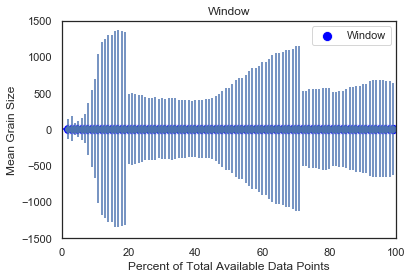

In [213]:
plt.xlim(0, 100)
plt.ylim(-1500,1500)
# plt.ylim(0,25)
plt.title('Window')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(window_percent, window_mean, s=100, color="blue", marker="o", label='Window')
plt.errorbar(window_percent, window_mean, yerr=window_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [89]:
window_percent_2=[]
for x in range(1,26):
    window_percent_2.append(x)

In [204]:
#reload data 2
raw_data = raw_data_slice_2
coords=raw_data_slice_2[:,3:5] 
grain_IDs=raw_data_slice_2[:,5]
grain_IDs_and_edges=raw_data_slice_2[:,5:7]
coords_and_grains=raw_data_slice_2[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_mean_2=[]
window_var_2=[]

for x in range(1,26):
    mean, var=grain_rect_count_vor(sqrt(x*100),hist=False,mean_var=True)
    window_mean_2.append(mean)
    window_var_2.append(var)

window_std_2=np.sqrt(window_var)

In [205]:
print(len(window_percent_2))
print(len(window_mean_2))

25
25


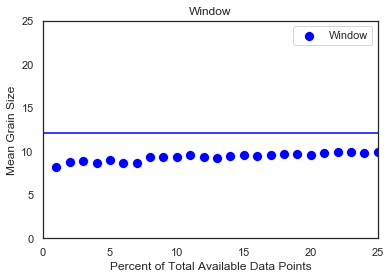

In [206]:
plt.xlim(0, 25)
# plt.ylim(-50000,50000)
plt.ylim(0,25)
plt.title('Window')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(window_percent_2, window_mean_2, s=100, color="blue", marker="o", label='Window')
# plt.errorbar(window_percent, window_mean, yerr=window_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [310]:
%store window_mean_2
%store window_var_2

Stored 'window_mean_2' (list)
Stored 'window_var_2' (list)


In [311]:
#reload data 3
raw_data = raw_data_slice_3
coords=raw_data_slice_3[:,3:5] 
grain_IDs=raw_data_slice_3[:,5]
grain_IDs_and_edges=raw_data_slice_3[:,5:7]
coords_and_grains=raw_data_slice_3[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_mean_3=[]
window_var_3=[]

for x in range(2,100):
    mean, var=grain_rect_count_vor(sqrt(x*100),hist=False,mean_var=True)
    window_mean_3.append(mean)
    window_var_3.append(var)

window_std_3=np.sqrt(window_var)

In [312]:
%store window_mean_3
%store window_var_3

Stored 'window_mean_3' (list)
Stored 'window_var_3' (list)


In [ ]:
#reload data 4
raw_data = raw_data_slice_4
coords=raw_data_slice_4[:,3:5] 
grain_IDs=raw_data_slice_4[:,5]
grain_IDs_and_edges=raw_data_slice_4[:,5:7]
coords_and_grains=raw_data_slice_4[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_mean_4=[]
window_var_4=[]

for x in range(2,100):
    mean, var=grain_rect_count_vor(sqrt(x*100),hist=False,mean_var=True)
    window_mean_4.append(mean)
    window_var_4.append(var)

window_std_4=np.sqrt(window_var)

In [ ]:
%store window_mean_4
%store window_var_4

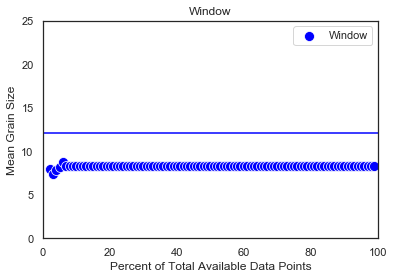

In [27]:
plt.xlim(0, 100)
# plt.ylim(-50000,50000)
plt.ylim(0,25)
plt.title('Window')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(window_percent, window_mean_3, s=100, color="blue", marker="o", label='Window')
# plt.errorbar(window_percent, window_mean, yerr=window_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [28]:
# # plt.xlim(0, 100)
# # plt.ylim(0, 1)
# #plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('Mean Grain Size')

# #window mean
# # sns.scatterplot(window_percent, window_mean, s=100, color="red", marker="o", label='mean')
# #window var
# sns.scatterplot(window_percent, window_var, s=100, color="blue", marker="o", label='var')

In [201]:
random_percent=[]
for x in range (10,87000,1000):
    random_percent.append((x/87000)*100)
    
grid_percent=[]
for x in range(1,25,1):
    grid_percent.append(((87017/x)/87017)*100)
    
fine_grid_percent=[]
for x in range(2,50,1):
    fine_grid_percent.append(((87017-(87017/x))/87017)*100)

In [51]:
random_mean=[]
random_var=[]

for x in range (10,87000,1000):
    mean, var=random_vor(x,hist=False,mean_var=True)
    random_mean.append(mean)
    random_var.append(var)

random_std=np.sqrt(random_var)   

In [62]:
%store random_mean
%store random_var

Stored 'random_mean' (list)
Stored 'random_var' (list)


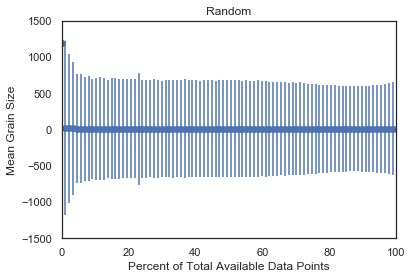

In [83]:
plt.xlim(0, 100)
plt.ylim(-1500,1500)
plt.title('Random')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
# sns.scatterplot(random_percent, random_mean, s=100, color="blue", marker="o")
plt.errorbar(random_percent, random_mean, yerr=random_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [195]:
def sobol_vor(sample,num_bins=25,hist=True,mean_var=False,replacement=False):
    #choose 2D sobol points
    sobol = (sobol_seq.i4_sobol_generate(2, sample))
    sobol[:,0]*=np.amax(raw_data[:,3])
    sobol[:,1]*=np.amax(raw_data[:,4])
    sobol_sample=raw_data[nearest_neighbors(sobol,coords),3:6]
    sobol_sample=sobol_sample[:,0]

    random_coords=sobol_sample[:,0:2]
    random_grain_IDs=sobol_sample[:,2]
    
    #get areas
    vol=voronoi_volumes(random_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [197]:
start = time.time()

sobol_mean=[]
sobol_var=[]

for x in range (10,87000,1000):
    mean, var=sobol_vor(x,hist=False,mean_var=True)
    sobol_mean.append(mean)
    sobol_var.append(var)

sobol_std=np.sqrt(sobol_var) 

end = time.time()
print(end - start)

5545.149842977524


In [199]:
5545/3600

1.5402777777777779

In [215]:
%store sobol_mean
%store sobol_var

Stored 'sobol_mean' (list)
Stored 'sobol_var' (list)


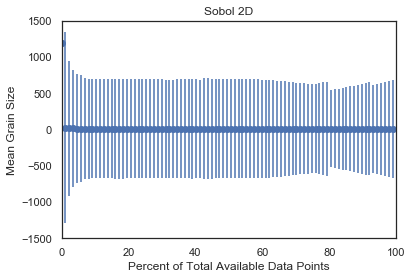

In [207]:
plt.xlim(0, 100)
plt.ylim(-1500,1500)
# plt.ylim(0,25)
plt.title('Sobol 2D')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
# sns.scatterplot(random_percent, sobol_mean, s=100, color="blue", marker="o")
plt.errorbar(random_percent, sobol_mean, yerr=sobol_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [386]:
def jitter_2(res,array,randomness=0,num_bins=25,hist=True,mean_var=False):
    #array of points to randomly sample after removing duplicates
    sampled=np.zeros((len(array),1))
    array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
    #row_IDs to access unsampled points
    row_IDs=np.arange(0,len(array))
    array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
    #total number of points to randomly sample
    grid_row_IDs=row_IDs[::res]
    grid_row_IDs=grid_row_IDs.reshape(-1,1)
    
    #introduce randomness
    minimum=np.zeros((len(grid_row_IDs),1))
    minimum=minimum-randomness
    maximum=np.ones((len(grid_row_IDs),1))
    maximum=maximum+randomness
    min_max=np.concatenate((minimum.reshape(-1,1),maximum.reshape(-1,1)),axis=1)
    
    #ensure the range of values in within the array
    
    #add/subtract randomness
    randomness_array=np.zeros((len(grid_row_IDs),1))
    for row in np.arange(len(grid_row_IDs)):
        randomness_array[row]=np.random.randint(int(min_max[row,0]),int(min_max[row,1]))
    
    #add array to create jitter
    jitter_array=grid_row_IDs+randomness_array
    
    #remove points outside of range (0,len)...
    in_range=np.where((jitter_array[:,0] >= 0) & (jitter_array[:,0] < len(array)))
#     print(len(in_range[0]))
#     out_of_range=np.where((jitter_array[:,0] < 0) | (jitter_array[:,0] >= len(array)))
#     print(len(out_of_range[0]))
    jitter_array=jitter_array[in_range]
    
    #...and add back in by random sampling
    random_array=array[np.random.choice(array.shape[0], (len(grid_row_IDs)-len(in_range[0])), replace=True), 4]
    random_array=random_array.reshape(-1,1)
    jitter_array=np.append(jitter_array,random_array)
    jitter_array=jitter_array.reshape(-1,1)
    
    #jitter sample data
    jitter_coords_and_grain_IDs=array[jitter_array.astype(int).flatten(),:]
    jitter_coords=jitter_coords_and_grain_IDs[:,0:2]
    jitter_grain_IDs=jitter_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(jitter_coords)
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    print(unique_IDs)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
    plt.title('Jitter Sampling, 50% of Data, Jitter = ' + str(randomness))
    plt.xlabel('Grain Size')
    plt.ylabel('Frequency')
    plt.xlim(0,250)
    plt.ylim(0,0.04)
    plt.hist(count, bins=26, range=(0,250), density=True)
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [28]:
#randomness is from 0 to 100, 0 is pure grid, 100 is pure random 
def jitter_grid_vor(res,randomness,binsize=249,hist=True,mean_var=False):
    #pure grid sampling
    grid_coords_and_grain_IDs=coords_and_grains_copy[::res]
    grid_coords=grid_coords_and_grain_IDs[:,0:2]
    grid_grain_IDs=grid_coords_and_grain_IDs[:,2]
    
    jitter_coords_and_grain_IDs=np.zeros(grid_coords_and_grain_IDs.shape[1])
    #array to hold sampled points
    sampled=np.zeros((len(coords_and_grains_copy),1))
    jitter_copy=np.concatenate((coords_and_grains_copy,sampled.reshape(-1,1)),axis=1)
    
    while len(jitter_coords_and_grain_IDs) < len(grid_coords_and_grain_IDs):
        jitter_array=jitter_copy[np.where(jitter_copy[:,3])==0]
        #scale res by 1 if grid (easy)
        #else scale res so it is inbetween start and last item (needs to be same as random)
        new_res=res*int(len(jitter_array)*random())
        jitter_coords_and_grain_IDs_slice=jitter_array[::res]    
            
            
    jitter_coords_and_grain_IDs=np.delete(jitter_coords_and_grain_IDs, 0, 0)
    jitter_coords=jitter_coords_and_grain_IDs[:,0:2]
    jitter_grain_IDs=jitter_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(jitter_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [45]:
grid_mean=[]
grid_var=[]

for x in range(1,25,1):
    mean, var=grid_vor(x,hist=False,mean_var=True)
    grid_mean.append(mean)
    grid_var.append(var)

grid_std=np.sqrt(grid_var)   

In [63]:
%store grid_mean
%store grid_var

Stored 'grid_mean' (list)
Stored 'grid_var' (list)


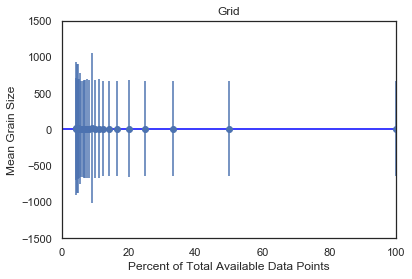

In [84]:
plt.xlim(0, 100)
plt.ylim(-1500,1500)
# plt.ylim(0,25)
plt.title('Grid')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
# sns.scatterplot(grid_percent, grid_mean, s=100, color="blue", marker="o")
plt.errorbar(grid_percent, grid_mean, yerr=grid_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [271]:
fine_grid_mean=[]
fine_grid_var=[]

for x in range(2,25,1):
    mean, var=fine_grid_vor(x,hist=False,mean_var=True)
    fine_grid_mean.append(mean)
    fine_grid_var.append(var)

fine_grid_std=np.sqrt(fine_grid_var)   

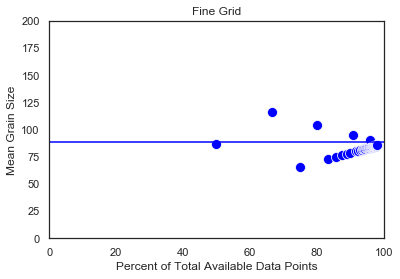

In [276]:
plt.xlim(0, 100)
plt.ylim(0,200)
plt.title('Fine Grid')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(fine_grid_percent, fine_grid_mean, s=100, color="blue", marker="o")
# plt.errorbar(fine_grid_percent, fine_grid_mean, yerr=fine_grid_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [50]:
random_divergence_scipy=[]
for i in range (1,87000,100):
    random_divergence_scipy.append(js_divergence_scipy(new_p(249), random(i)))

In [116]:
grid_divergence_scipy=[]
for i in range(1,50,1):
    grid_divergence_scipy.append(js_divergence_scipy(new_p(249),grid(i)))

In [391]:
fine_grid_divergence_scipy=[]
for i in range(2,100,1):
    fine_grid_divergence_scipy.append(js_divergence_scipy(new_p(249), fine_grid(i)))

In [ ]:
window_divergence_scipy=[]
for i in range(2,100,1):
    window_divergence_scipy.append(js_divergence_scipy(new_p(249), grain_rect_count(sqrt(i*100))))

In [ ]:
random_divergence_scipy=[]
for i in range (1,87000,100):
    random_divergence_scipy.append(js_divergence_scipy(new_p(249), random(i)))

In [390]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# #plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')
# plt.title('Proportional Scaling')

# #SciPy, log2
# #random
# sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="blue", marker="o", label='Random')
# #grid
# sns.scatterplot(grid_percent, grid_divergence_scipy, s=100, color="red", marker="o", label='Grid')
# #fine grid
# sns.scatterplot(fine_grid_percent, fine_grid_divergence_scipy, s=100, color="green", marker="o", label='Fine Grid')
# #window
# sns.scatterplot(window_percent_two, window_avg, s=100, color="gold", marker="o", label='Window')

# # #window
# # #top left
# # plt.axhline(y=tld, color='purple', linestyle='-',label='top left')
# # #top right
# # plt.axhline(y=trd, color='purple', linestyle='-',label='top right')
# # #bottom right
# # plt.axhline(y=brd, color='purple', linestyle='-',label='bottom right')
# # #bottom left
# # plt.axhline(y=bld, color='purple', linestyle='-',label='bottom left')

# # #grid
# # #top left
# # plt.axhline(y=zero, color='green', linestyle='-',label='zero')
# # #top right
# # plt.axhline(y=one, color='green', linestyle='-',label='one')
# # #bottom right
# # plt.axhline(y=two, color='green', linestyle='-',label='two')
# # #bottom left
# # plt.axhline(y=three, color='green', linestyle='-',label='three')

In [16]:
window_percent_two=[]
for x in range (1,101,1):
    window_percent_two.append(x)

In [280]:
window_divergence_one=[]
for x in range (1,101,1):
    window_divergence_one.append(js_divergence_scipy(new_p(249), grain_rect_count_1(sqrt(x*100),sqrt(x*100))))

In [281]:
window_divergence_two=[]
for x in range (1,101,1):
    window_divergence_two.append(js_divergence_scipy(new_p(249), grain_rect_count_2(100-sqrt(x*100),100-sqrt(x*100))))

In [282]:
window_divergence_three=[]
for x in range (1,101,1):
    window_divergence_three.append(js_divergence_scipy(new_p(249), grain_rect_count_3(sqrt(x*100),100-sqrt(x*100))))

In [283]:
window_divergence_four=[]
for x in range (1,101,1):
    window_divergence_four.append(js_divergence_scipy(new_p(249), grain_rect_count_4(100-sqrt(x*100),sqrt(x*100))))

In [408]:
#top left
tld=js_divergence(new_p(249),grain_rect_count_3(50,50))
#top right
trd=js_divergence(new_p(249),grain_rect_count_2(50,50))
#bottom right
brd=js_divergence(grain_rect_count_4(50,50),new_p(249))
#bottom left
bld=js_divergence(grain_rect_count_1(50,50),new_p(249))

In [389]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# plt.title('Window Divergences Compared')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')

# #window one
# sns.scatterplot(window_percent_two, window_divergence_one, s=100, color="red", marker="o", label='Window One')
# # #bottom left
# # plt.axhline(y=bld, color='red', linestyle='-',label='bottom left')

# #window two
# sns.scatterplot(window_percent_two, window_divergence_two, s=100, color="green", marker="o", label='Window Two')
# # #top right
# # plt.axhline(y=trd, color='green', linestyle='-',label='top right')

# #window three
# sns.scatterplot(window_percent_two, window_divergence_three, s=100, color="blue", marker="o", label='Window Three')
# # #top left
# # plt.axhline(y=tld, color='blue', linestyle='-',label='top left')

# #window four
# sns.scatterplot(window_percent_two, window_divergence_four, s=100, color="purple", marker="o", label='Window Four')
# # #bottom right
# # plt.axhline(y=brd, color='purple', linestyle='-',label='bottom right')

# #Voronoi
# sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="gold", marker="o", label='Voronoi Random')

In [388]:
# #window avg
# window_array=np.array([window_divergence_one,window_divergence_two,window_divergence_three,window_divergence_four])
# # print(window_array)
# window_avg=(window_array.sum(axis=0))/4
# sns.scatterplot(window_percent_two, window_avg, s=100, color="blue", marker="o", label='Window Average')

In [85]:
window_percent_two=[]
for x in range (1,101,1):
    window_percent_two.append(x)

In [459]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# plt.title('Voronoi Scaling')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')

# #Random
# # sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
# sns.lineplot(vor_random_percent, voronoi_random_divergence, color="blue", label='Random, No Replacement')
# #Random wtih duplicates
# # # sns.scatterplot(vor_random_percent_2, voronoi_random_divergence_replace, s=100, color="blue", marker="o", label='Random, Duplicates')
# # sns.lineplot(vor_random_percent_2, voronoi_random_divergence_replace, color="blue", label='Random, Replacement')
# #Grid
# # sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
# sns.lineplot(vor_grid_percent, voronoi_grid_divergence, color="red", label='Grid')
# #Fine Grid
# # # sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="red", marker="o", label='Grid')
# sns.lineplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, color="red", label='Fine Grid')
# # # #Jitter One
# # # sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_1, s=100, color="purple", marker="o", label='Jitter=0')
# # sns.lineplot(vor_jitter_percent, voronoi_jitter_divergence_1, color="purple", label='Jitter=0')
# # # #Jitter 9
# # # sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_9, s=100, color="purple", marker="o", label='Jitter=1')
# # sns.lineplot(vor_jitter_percent_2, voronoi_jitter_divergence_9, color="purple", label='Jitter=1')
# # # #Jitter 8
# # # sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_8, s=100, color="purple", marker="o", label='Jitter=2')
# # # sns.lineplot(vor_jitter_percent, voronoi_jitter_divergence_8, color="purple", label='Jitter=2')

In [387]:
# plt.xlim(0, 100)
# plt.ylim(0, 0.95)
# plt.title('Voronoi Scaling')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')

# #Voronoi
# sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
# # #Scaled
# # # sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="blue", marker="+", label='Scaled Random')
# # #Voronoi
# sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
# # #Scaled
# # # sns.scatterplot(grid_percent, grid_divergence_scipy, s=100, color="red", marker="+", label='Scaled Grid')
# # #Voronoi
# sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
# # #Scaled
# # # sns.scatterplot(fine_grid_percent, fine_grid_divergence_scipy, s=100, color="green", marker="+", label='Scaled Fine Grid')
# # #Window 
# sns.scatterplot(window_percent_two, window_avg, s=100, color="gold", marker="o", label='Window')

In [ ]:
# vor_jitter_percent=[]
# for x in range(1,25,1):
#     vor_jitter_percent.append(((87017/x)/87017)*100)

# voronoi_jitter_divergence_2=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_2.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,100)))

# voronoi_jitter_divergence_3=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_3.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,50)))

# voronoi_jitter_divergence_4=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_4.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,25)))

# voronoi_jitter_divergence_5=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_5.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,12)))

# voronoi_jitter_divergence_6=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_6.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,6)))

# voronoi_jitter_divergence_7=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_7.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,3)))

# voronoi_jitter_divergence_8=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_8.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,2)))

# voronoi_jitter_divergence_9=[]
# for x in range(1,25,1):
#     try:
#         voronoi_jitter_divergence_9.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,1)))
#     except:
#         print('Exception at x = '+str(x))

# voronoi_jitter_divergence_9.remove(0)

# vor_jitter_percent_2=[]
# for x in range(1,25,1):
#     vor_jitter_percent_2.append(((87017/x)/87017)*100)
    
# vor_jitter_percent_2.remove(vor_jitter_percent_2[12])
# vor_jitter_percent_2.remove(vor_jitter_percent_2[22])

# voronoi_jitter_divergence_1=[]
# for x in range(1,25,1):
#     voronoi_jitter_divergence_1.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,0)))

# %store voronoi_jitter_divergence_8
# %store voronoi_jitter_divergence_9

In [69]:
window_percent=[]
for x in range (1,26,1):
    window_percent.append(x)
    
#reload data
raw_data = raw_data_slice_1
coords=raw_data_slice_1[:,3:5] 
grain_IDs=raw_data_slice_1[:,5]
# grain_IDs_and_edges=raw_data_slice_1[:,5:7]
coords_and_grains=raw_data_slice_1[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_divergence_one=[]
for x in range (1,26,1):
    window_divergence_one.append(js_divergence_scipy(k3, grain_rect_count_vor(sqrt(x*100))))

#reload data
raw_data = raw_data_slice_2
coords=raw_data_slice_2[:,3:5] 
grain_IDs=raw_data_slice_2[:,5]
# grain_IDs_and_edges=raw_data_slice_2[:,5:7]
coords_and_grains=raw_data_slice_2[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_divergence_two=[]
for x in range (1,26,1):
    window_divergence_two.append(js_divergence_scipy(k3, grain_rect_count_vor(sqrt(x*100))))

#reload data
raw_data = raw_data_slice_3
coords=raw_data_slice_3[:,3:5] 
grain_IDs=raw_data_slice_3[:,5]
# grain_IDs_and_edges=raw_data_slice_3[:,5:7]
coords_and_grains=raw_data_slice_3[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_divergence_three=[]
for x in range (1,26,1):
    window_divergence_three.append(js_divergence_scipy(k3, grain_rect_count_vor(sqrt(x*100))))
    
#reload data
raw_data = raw_data_slice_4
coords=raw_data_slice_4[:,3:5] 
grain_IDs=raw_data_slice_4[:,5]
# grain_IDs_and_edges=raw_data_slice_4[:,5:7]
coords_and_grains=raw_data_slice_4[:,3:6]
coords_and_grains_copy=np.copy(coords_and_grains)

window_divergence_four=[]
for x in range (1,26,1):
    window_divergence_four.append(js_divergence_scipy(k3, grain_rect_count_vor(sqrt(x*100))))

plt.xlim(0, 25)
plt.ylim(0, 1)
plt.title('Window Divergences Compared')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#window one
sns.scatterplot(window_percent, window_divergence_one, s=100, color="red", marker="o", label='Window One')

#window two
sns.scatterplot(window_percent, window_divergence_two, s=100, color="green", marker="o", label='Window Two')

#window three
sns.scatterplot(window_percent, window_divergence_three, s=100, color="blue", marker="o", label='Window Three')

#window four
sns.scatterplot(window_percent, window_divergence_four, s=100, color="purple", marker="o", label='Window Four')

#window avg
window_array=np.array([window_divergence_one,window_divergence_two,window_divergence_three,window_divergence_four])
window_avg=(window_array.sum(axis=0))/4

sns.scatterplot(window_percent, window_avg, s=100, color="blue", marker="o", label='Window Average')

In [246]:
vor_grid_percent=[]
for i in range(1,25,1):
    vor_grid_percent.append(((87017/i)/87017)*100)
    
# vor_fine_grid_percent=[]
# for i in range(2,25,1):
#     vor_fine_grid_percent.append(((87017-(87017/i))/87017)*100)
    
vor_random_percent=[]
for i in range (100,26000,1000):
    vor_random_percent.append((i/87000)*100)

vor_random_percent_2=[]
for i in range (100,88000,1000):
    vor_random_percent_2.append((i/87000)*100)
    
window_percent=[]
for x in range (1,26,1):
    window_percent.append(x)

In [38]:
voronoi_grid_divergence=[]
for x in range(1,25,1):
    voronoi_grid_divergence.append(js_divergence_scipy(k3, grid_vor(x)))

In [402]:
# voronoi_fine_grid_divergence=[]
# for x in range(2,25,1):
#     voronoi_fine_grid_divergence.append(js_divergence_scipy(k3, fine_grid_vor(x)))

In [66]:
voronoi_random_divergence=[]
for x in range (100,26000,1000):
    voronoi_random_divergence.append(js_divergence_scipy(k3, new_grid_vor(x)))

In [67]:
voronoi_square_grid_divergence=[]
for x in range (100,26000,1000):
    voronoi_square_grid_divergence.append(js_divergence_scipy(k3, new_grid_vor(x)))

In [28]:
voronoi_hexagonal_grid_divergence=[]
for x in range (100,26000,1000):
    voronoi_hexagonal_grid_divergence.append(js_divergence_scipy(k3, new_grid_vor(x,square=False)))

In [35]:
window_divergence_vor=[]
for x in range (1,26,1):
    window_divergence_vor.append(js_divergence_scipy(k3, grain_rect_count_vor(sqrt(x*100))))

In [57]:
window_avg=list(window_avg)

In [34]:
#add divergence at 100%
vor_random_percent.append(100)
voronoi_random_divergence.append(0)
# voronoi_random_divergence_replace.append(0.08420902459423057)

window_percent.append(0)
window_avg.append(1)

vor_grid_percent.append(0)
voronoi_grid_divergence.append(1)

vor_grid_percent.append(1)
voronoi_grid_divergence.append(0.7380891294936394)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [35]:
vor_grid_percent.append(0)
voronoi_grid_divergence.append(1)

vor_grid_percent.append(1)
voronoi_grid_divergence.append(0.7380891294936394)

In [68]:
%store -r

In [179]:
voronoi_grid_divergence.pop()

1

In [171]:
print(window_avg)

[0.21135671980396326, 0.13292139797566815, 0.11925692756903228, 0.0998172473905786, 0.08366611089918022, 0.07776819870294414, 0.0683201626151837, 0.053606384244009125, 0.04662248610223341, 0.057497931425388525, 0.05017228334512001, 0.045157421580581995, 0.0399202241843094, 0.03433829011116121, 0.03149856286327021, 0.03134094699886755, 0.030982287220210562, 0.031548700832625315, 0.02897745195714175, 0.021706068767716365, 0.022544644799190702, 0.02702233892781504, 0.02201078868276705, 0.024629042655885516, 0.017755442281225803, 1]


In [172]:
window_percent.append(0)

In [183]:
print(len(vor_grid_percent))
print(len(voronoi_grid_divergence))

26
26


In [30]:
%store -r

In [70]:
voronoi_square_grid_divergence.append(0)
voronoi_hexagonal_grid_divergence.append(0)

In [75]:
voronoi_random_divergence.append(0)

In [81]:
print(len(vor_random_percent))
print(len(voronoi_hexagonal_grid_divergence))

27
24


In [84]:
voronoi_hexagonal_grid_divergence.append(0)

In [94]:
print(len(vor_random_percent))
print(len(golden_divergence))

28
27


In [248]:
%store -r

In [ ]:
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.title('Grain Area Distribution')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Random wtih duplicates
# sns.scatterplot(vor_random_percent_2, voronoi_random_divergence_replace, s=100, color="purple", marker="o", label='Random, Duplicates')
#Window 
# sns.scatterplot(window_percent, window_divergence_vor, s=100, color="gold", marker="o", label='Window')
sns.lineplot(window_percent, window_avg, color="black", label='Window')
#Grid
# sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
# sns.lineplot(vor_grid_percent, voronoi_grid_divergence, color="yellow", label='1D Grid')
#Random, Replacement
# sns.lineplot(vor_random_percent_2, voronoi_random_divergence_replace, color="blue", label='Random, Replacement')
#1D Golden Ratio 
sns.lineplot(vor_random_percent, golden_divergence, color="gold", label='2D Golden Ratio')
#2D Sobol
sns.lineplot(vor_random_percent, sobol_divergence, color="purple", label='2D Sobol')
#Square Grid
sns.lineplot(vor_random_percent, voronoi_square_grid_divergence, color="red", label='Square Grid')
#Hex Grid
sns.lineplot(vor_random_percent, voronoi_hexagonal_grid_divergence, color="green", label='Hex Grid')
#Random
# sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
sns.lineplot(vor_random_percent, voronoi_random_divergence, color="blue", label='Random, No Replacement')

In [86]:
%store vor_random_percent
%store window_percent
%store vor_grid_percent
%store voronoi_random_divergence
%store window_avg
%store voronoi_grid_divergence
%store golden_divergence
%store sobol_divergence
%store voronoi_square_grid_divergence
%store voronoi_hexagonal_grid_divergence

Stored 'vor_random_percent' (list)
Stored 'window_percent' (list)
Stored 'vor_grid_percent' (list)
Stored 'voronoi_random_divergence' (list)
Stored 'window_avg' (ndarray)
Stored 'voronoi_grid_divergence' (list)
Stored 'golden_divergence' (list)
Stored 'sobol_divergence' (list)
Stored 'voronoi_square_grid_divergence' (list)
Stored 'voronoi_hexagonal_grid_divergence' (list)


In [133]:
voronoi_random_divergence_replace=[]
for x in range (100,26000,1000):
    try:
        voronoi_random_divergence_replace.append(js_divergence_scipy(k3, random_vor(x,replacement=True)))
    except:
        print('Exception at x = '+str(x))

In [232]:
sobol_divergence=[]
for x in range (100,26000,1000):
    try:
        sobol_divergence.append(js_divergence_scipy(k3, sobol_vor(x)))
    except:
        print('Exception at x = '+str(x))

In [233]:
golden_divergence=[]
for x in range (100,26000,1000):
    try:
        golden_divergence.append(js_divergence_scipy(k3, golden_vor(x)))
    except:
        print('Exception at x = '+str(x))

In [234]:
# voronoi_random_divergence_replace.append(1)
sobol_divergence.append(1)
golden_divergence.append(1)

In [242]:
voronoi_random_divergence_replace.append(1)

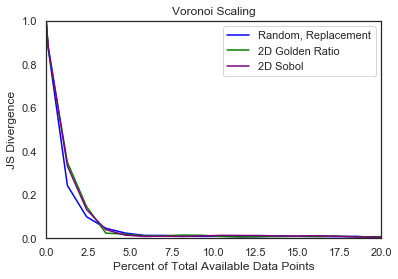

In [243]:
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('Voronoi Scaling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Random, Replacement
sns.lineplot(vor_random_percent, voronoi_random_divergence_replace, color="blue", label='Random, Replacement')
#1D Golden Ratio 
sns.lineplot(vor_random_percent, golden_divergence, color="green", label='2D Golden Ratio')
#2D Sobol
sns.lineplot(vor_random_percent, sobol_divergence, color="purple", label='2D Sobol')

In [244]:
%store sobol_divergence
%store golden_divergence

Stored 'sobol_divergence' (list)
Stored 'golden_divergence' (list)


In [31]:
def jitter(array,num_boxes,percent,binsize=249,hist=True,mean_var=False): 
    
    #array to hold (un)sampled points
    sampled=np.zeros((len(raw_data),1))
    array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
    #row_IDs to access unsampled points
    row_IDs=np.arange(0,len(raw_data))
    array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
    #total number of points to randomly sample
    num_points=len(array)*(percent/100)
    
    #number of points to randomly sample in each box
    num_box_points=int(num_points/num_boxes)
    
    #a=l^2 (i.e. 22, 4x4 etc)
    square_dim=np.sqrt(num_boxes)
    
    #side length of the square
    x_total_side_len=float(max(raw_data[:,3]))
    y_total_side_len=float(max(raw_data[:,4]))
    
    #side length of each jitter square
    x_side_len=x_total_side_len/square_dim
    y_side_len=y_total_side_len/square_dim
    
    #number of sides to iterate for loop
    num_sides=int(round(x_total_side_len/x_side_len))
    
    #create array to hold the result
    jittered_array=np.zeros(array.shape[1])
    
    num_points_lost=0
    
    #break down into gridded sample 
    lower_x_bound=0
    lower_y_bound=0
    
    new_x_side_len=x_side_len
    for x in range(0,num_sides,1): 
        x_slice=array[np.where((lower_x_bound<=array[:,3]) & (array[:,3]<new_x_side_len))]
#         print(str(lower_x_bound)+', '+str(new_x_side_len))
        lower_x_bound+=x_side_len
        new_x_side_len+=x_side_len
        
#         print(len(x_slice))
        
        lower_y_bound=0
        new_y_side_len=y_side_len
        for y in range(0,num_sides,1):
            y_slice=array[np.where((lower_y_bound<=x_slice[:,4]) & (x_slice[:,4]<new_y_side_len))]
#             print(str(lower_y_bound)+', '+str(new_y_side_len))
            lower_y_bound+=y_side_len
            new_y_side_len+=y_side_len
        
#             print(len(y_slice))
            
            #randomly sample points in box, box might have less than avg number of points, throwing an exception
            try:
                random_boxed_points=y_slice[np.random.choice(y_slice.shape[0], num_box_points, replace=False), :]
            #if exception, just use all of the points
            except:
                random_boxed_points=y_slice
                num_points_lost+=num_box_points-len(y_slice)

            array[[y_slice[:,7].astype(int)],6]=1
            jittered_array=np.vstack((jittered_array,random_boxed_points))
            
    #delete the placeholder first row of the answer     
    jittered_array=np.delete(jittered_array, 0, 0)
    
    #randomly sample the unsampled points (due to rounding errors, irregularities, etc)
    unsampled=array[np.where(array[:,6]!=1)]
    unsampled=unsampled[np.random.choice(unsampled.shape[0], num_points_lost, replace=False), :]
    jittered_array=np.vstack((jittered_array,unsampled))

#     print(len(jittered_array))








    
    #turn into prob vec
    jitter_coords=jittered_array[:,[3,4]]
    jitter_grain_IDs=jittered_array[:,5]
    
    #get areas
    vol=voronoi_volumes(jitter_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [112]:
js_divergence_scipy(k2,jitter(raw_data,1,100))

0.0

In [114]:
#Create curves using different box sizes (with randomly sampled points within)
#Box size of point dim should be same as grid, one box (total of len(array) boxes) should be like random

vor_jitter_percent=[]
for x in range(1,101,2):
    vor_jitter_percent.append(x)

voronoi_jitter_divergence_1=[]
for x in range(1,101,2):
    voronoi_jitter_divergence_1.append(js_divergence_scipy(k2, jitter(raw_data,1,x)))

voronoi_jitter_divergence_16=[]
for x in range(1,101,2):
    voronoi_jitter_divergence_16.append(js_divergence_scipy(k2, jitter(raw_data,16,x)))

voronoi_jitter_divergence_484=[]
for x in range(1,101,2):
    voronoi_jitter_divergence_484.append(js_divergence_scipy(k2, jitter(raw_data,484,x)))

voronoi_jitter_divergence_3136=[]
for x in range(1,101,3):
    voronoi_jitter_divergence_3136.append(js_divergence_scipy(k2, jitter(raw_data,3136,x)))

voronoi_jitter_divergence_12544=[]
for x in range(1,101,3):
    voronoi_jitter_divergence_12544.append(js_divergence_scipy(k2, jitter(raw_data,12544,x)))

voronoi_jitter_divergence_86436=[]
for x in range(1,101,4):
    voronoi_jitter_divergence_86436.append(js_divergence_scipy(k2, jitter(raw_data,86436,x)))

%store voronoi_jitter_divergence_1
%store voronoi_jitter_divergence_16
%store voronoi_jitter_divergence_484
%store voronoi_jitter_divergence_3136
%store voronoi_jitter_divergence_12544
%store voronoi_jitter_divergence_86436

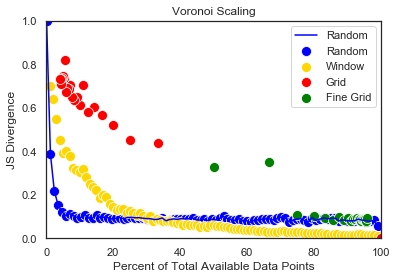

In [172]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Voronoi Scaling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Random
sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
# sns.lineplot(vor_random_percent, voronoi_random_divergence, color="blue", label='Random')
#Random wtih duplicates
sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
#Window 
sns.scatterplot(window_percent, window_divergence_vor, s=100, color="gold", marker="o", label='Window')
#Grid
sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
#Fine Grid
sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
#Jitter (1 subsquare)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_1, s=100, color="pink", marker="o", label='Jitter 1')
#Jitter (16 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_16, s=100, color="pink", marker="o", label='Jitter 16')
#Jitter (484 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_484, s=100, color="pink", marker="o", label='Jitter 484')
# #Jitter (3136 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_3136, s=100, color="pink", marker="o", label='Jitter 3136')
# #Jitter (12544 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_12544, s=100, color="pink", marker="o", label='Jitter 12544')
# #Jitter (86436 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_86436, s=100, color="pink", marker="o", label='Jitter 86436')

In [410]:
voronoi_random_divergence_2=[]
for x in range (100,87000,1000):
#     print(x)
    voronoi_random_divergence_2.append(js_divergence_scipy(k2, random_vor(x)))

In [411]:
window_divergence_vor_2=[]
for x in range (1,101,3):
    window_divergence_vor_2.append(js_divergence_scipy(k2, grain_rect_count_vor(sqrt(x*100))))

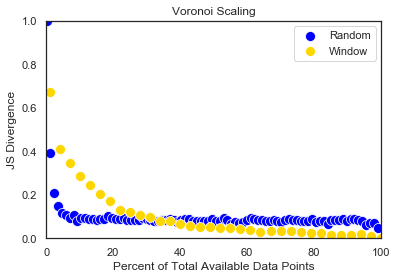

In [414]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Voronoi Scaling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Voronoi
sns.scatterplot(vor_random_percent, voronoi_random_divergence_2, s=100, color="blue", marker="o", label='Random')
# #Window 
sns.scatterplot(window_percent_two, window_divergence_vor_2, s=100, color="gold", marker="o", label='Window')
#Grid
# sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
#Fine Grid
# sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')

In [37]:
def divergence_graph(binsize):
    p=new_p(binsize)

    random_divergence=[]
    for i in range (1,87000,100):
        random_divergence.append(js_divergence(p, random(i,binsize), binsize))
    
    grid_divergence=[]
    for i in range(1,50,1):
        grid_divergence.append(js_divergence(p,grid(i,binsize), binsize))
    
    fine_grid_divergence=[]
    for i in range(2,100,1):
        fine_grid_divergence.append(js_divergence(p, fine_grid(i,binsize), binsize))
    
    #plot
    plt.xlim(0, 100)
    plt.ylim(0, 1)
    #plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
    plt.xlabel('Percent of Total Available Data Points')
    plt.ylabel('JS Divergence')

    #random
    sns.scatterplot(random_percent, random_divergence, s=100, color="purple", marker="o")
    #grid
    sns.scatterplot(grid_percent, grid_divergence, s=100, color="green", marker="o")
    #fine grid
    sns.scatterplot(fine_grid_percent, fine_grid_divergence, s=100, color="blue", marker="o")
    #window
    sns.scatterplot(window_percent, window_divergence_scipy, s=100, color="purple", marker="o", label='window')

    #top and bottom rectangles
    plt.axhline(y=tbd, color='orange', linestyle='-')
    #right and left rectangles
    plt.axhline(y=lrd, color='yellow', linestyle='-')
    #top right and bottom left squares - smaller and higher divergence
    plt.axhline(y=trbl, color='red', linestyle='-')
    #could try from bottom left and top right if we want more data points

In [17]:
#load data
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))
raw_data_copy=np.copy(raw_data)

In [70]:
a=sqrt(0.75)

#12 hexagonal close-packed crystal symmetry operators
op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
op29=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36

#list of hexagonal sym ops
hex_sym_ops=[op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36]

In [71]:
#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    #problem here!!!
#     delta_gd=np.matmul((np.matmul(g_two,sym_op)),(np.matmul(np.linalg.inv(sym_op),np.linalg.inv(g_one))))
    #formula from powerpoint
    delta_gd=np.matmul(sym_op,delta_g)
    
#     #angle in radians
#     theta=np.arccos((np.trace(delta_gd)-1)/2)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


In [72]:
#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two,sym_ops):
    misorientation_list=[]
    for sym_op in sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)
#     return misorientation_list

In [73]:
def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

In [74]:
def grain_centers(array):
    unique_grain_IDs=np.unique(array[:,5])
    centers=np.array([0,0,0])

    for grain_ID in unique_grain_IDs:
        grain_xvals=array[np.where(array[:,5]==grain_ID),3]
        grain_yvals=array[np.where(array[:,5]==grain_ID),4]
        x_avg=np.mean(grain_xvals)
        y_avg=np.mean(grain_yvals)
        center=np.array([grain_ID,x_avg,y_avg])
        centers=np.vstack((centers,center))
    
    centers=np.delete(centers, 0, 0)
    
#     plt.xlim(0,11)
#     plt.ylim(0,11)
#     sns.scatterplot(x=centers[:,1],y=centers[:,2],marker='o',color='red')
    
    return centers[:,1:3]

In [75]:
#plot js divergence of boundary dist
def boundaries_and_centers(array,binsize=249,boundary_plot=False,hist=False):
    boundaries=np.zeros((len(array),1))
    raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)
    
    #create ajd dict
    modified_vor_adj=mod_adj_dict(array)
    
    #create list of boundary disorientations
    boundaries=[]
    for key in modified_vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in modified_vor_adj[key]:
            euler_two=[raw_data[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > 15:
                boundaries.append(vor_disorient)
                raw_data_and_boundaries[key,6]=1
                raw_data_and_boundaries[value,6]=1
    
    raw_data_and_boundaries_slice=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,6]==1)]
    
    plt.xlim(0,11)
    plt.ylim(0,11)
    sns.scatterplot(x=raw_data_and_boundaries_slice[:,3],y=raw_data_and_boundaries_slice[:,4],marker='+')
    plt.scatterplot()


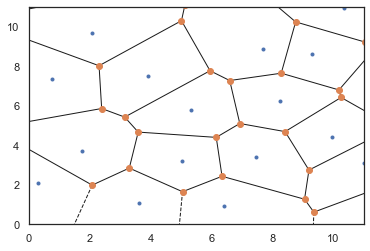

In [130]:
vor = Voronoi(grain_centers(raw_data))
fig = voronoi_plot_2d(vor)
plt.xlim(0,11)
plt.ylim(0,11)
plt.show()

In [76]:
def mod_adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            #remove to prevent duplicates
#             neigh[j].add(i)
    return neigh

In [77]:
#plot js divergence of boundary dist
def boundary_hist(array,boundary_plot=False,hist=False):    
    boundaries=np.zeros((len(array),1))
    raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)
    
    #create ajd dict
    modified_vor_adj=mod_adj_dict(array)
    
    #create list of boundary disorientations
    boundaries=[]
    for key in modified_vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in modified_vor_adj[key]:
            euler_two=[array[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > 15:
                boundaries.append(vor_disorient)
                raw_data_and_boundaries[key,6]=1
                raw_data_and_boundaries[value,6]=1
    
    if boundary_plot==True:
        raw_data_and_boundaries_slice=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,6]==1)]
        plt.xlim(0,11)
        plt.ylim(0,11)
        sns.scatterplot(x=raw_data_and_boundaries_slice[:,3],y=raw_data_and_boundaries_slice[:,4],marker='+')
    
    if hist==True:
        plt.hist(boundaries, bins=np.arange(15,100,5), range=(15,100), density=True) 
        
    return boundaries
        
#     q_hist, q_bin_edges = np.histogram(boundaries, bins=np.arange(15,100), range=(15,100), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

# #     #if none, return zeros?

In [273]:
boundaries=boundary_hist(raw_data)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos


In [275]:
print(np.mean(boundaries))

52.726246105853086


(array([0.01175337, 0.01490762, 0.01814341, 0.01855483, 0.01368817,
        0.01098983, 0.00942568, 0.00883263, 0.01096388, 0.01138642,
        0.01020034, 0.01272077, 0.01162735, 0.01452214, 0.01892919,
        0.0033544 ]),
 array([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
 <a list of 16 Patch objects>)

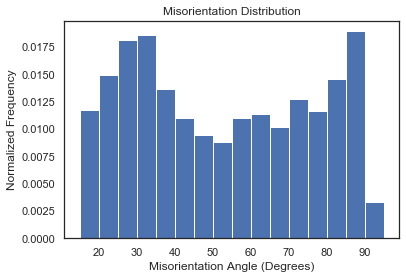

In [423]:
plt.title("Misorientation Distribution")
plt.xlabel('Misorientation Angle (Degrees)')
plt.ylabel('Normalized Frequency')
plt.hist(boundaries, bins=np.arange(15,100,5), range=(15,100), density=True) 

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


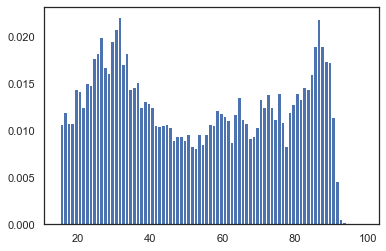

In [309]:
boundary_p=boundary_hist(raw_data,hist=True)

In [78]:
def random_boundary(sample):
    random_raw_data=raw_data[np.random.choice(raw_data.shape[0], sample, replace=False), :]
    return boundary_hist(random_raw_data,hist=True)

In [79]:
def grid_boundary(res,start=0):
    grid_raw_data=raw_data[start::res]
    return boundary_hist(grid_raw_data)

In [80]:
def fine_grid_boundary(res):
    arr = np.arange(0,len(raw_data),res)
    mask = np.ones(len(raw_data), dtype=bool)
    mask[arr] = False
    fine_grid_raw_data = raw_data[mask]
    return boundary_hist(fine_grid_raw_data)

In [81]:
def window_boundary(percent):
    percent=percent/100
    row_list=[]
    for index in range(0,len(raw_data)):
        if (raw_data[index,0]<int((110*percent))) and (raw_data[index,1]<int((110*percent))):
            row_list.append(raw_data[index])
        else:
            continue

    row_tuple=tuple(row_list)
    raw_data_slice=np.vstack(row_tuple)
    
    return boundary_hist(raw_data_slice, hist=True)

In [191]:
random_boundary_percent=[]
for x in range (100,87000,1000):
    random_boundary_percent.append((x/87000)*100)
    
grid_boundary_percent=[]
for x in range(1,25,1):
    grid_boundary_percent.append(((87017/x)/87017)*100)
    
fine_grid_boundary_percent=[]
for x in range(2,25,1):
    fine_grid_boundary_percent.append(((87017-(87017/x))/87017)*100)
    
window_boundary_percent=[]
for x in range(1,100,1):
    window_boundary_percent.append(x)

In [1]:
random_boundaries=[]
for x in range (100,87000,1000):
    random_boundaries.append(js_divergence_scipy(boundary_p, random_boundary(x)))

In [193]:
grid_boundaries=[]
for x in range(1,25,1):
    grid_boundaries.append(js_divergence_scipy(boundary_p, grid_boundary(x)))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [194]:
fine_grid_boundaries=[]
for x in range(2,25,1):
    fine_grid_boundaries.append(js_divergence_scipy(boundary_p, fine_grid_boundary(x)))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [195]:
window_boundaries=[]
for x in range(1,100,1):
    window_boundaries.append(js_divergence_scipy(boundary_p, window_boundary(sqrt(x*100))))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


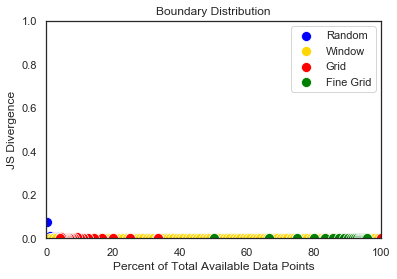

In [199]:
plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Dataset and Grid Sampled Subset')
plt.title('Boundary Distribution')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
#Random
sns.scatterplot(random_boundary_percent, random_boundaries, s=100, color="blue", marker="o", label='Random')
#Window
sns.scatterplot(window_boundary_percent, window_boundaries, s=100, color="gold", marker="o", label='Window')
#Grid
sns.scatterplot(grid_boundary_percent, grid_boundaries, s=100, color="red", marker="o", label='Grid')
#Fine Grid
sns.scatterplot(fine_grid_boundary_percent, fine_grid_boundaries, s=100, color="green", marker="o", label='Fine Grid')

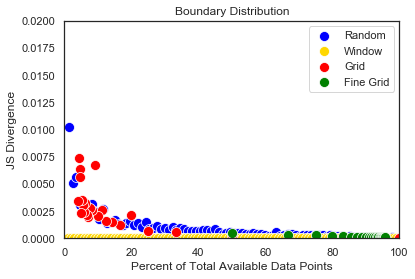

In [315]:
plt.xlim(0, 100)
plt.ylim(0, 0.02)
#plt.title('JS Divergence of Dataset and Grid Sampled Subset')
plt.title('Boundary Distribution')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
#Random
sns.scatterplot(random_boundary_percent, random_boundaries, s=100, color="blue", marker="o", label='Random')
#Window
sns.scatterplot(window_boundary_percent, window_boundaries, s=100, color="gold", marker="o", label='Window')
#Grid
sns.scatterplot(grid_boundary_percent, grid_boundaries, s=100, color="red", marker="o", label='Grid')
#Fine Grid
sns.scatterplot(fine_grid_boundary_percent, fine_grid_boundaries, s=100, color="green", marker="o", label='Fine Grid')

In [20]:
#start with nucleus
def rec_vor(row_ID,grain_ID,data_sample,angle):
    #assign angle
    euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
    #sample each surrounding point
    for row_ID_2 in new_vor_adj[row_ID]:
        #make sure grain grows outwards, 'memoization'
        if data_sample[row_ID_2,5]==0:
            #assign second angle
            euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
            #if they have a similar orientation, add to the grain, recursivly search
#             if (misorientation(euler_one,euler_two) <= angle):
            if (disorientation(euler_one, euler_two,hex_sym_ops) <= angle):
                # prevent infinite flip-flop recursion
                if data_sample[row_ID_2,5] != grain_ID:
                    data_sample[row_ID_2,5]=grain_ID
                    rec_vor(row_ID_2,grain_ID,data_sample,angle)
            #label edges
            else:
                data_sample[row_ID,6]=1
                data_sample[row_ID_2,6]=1

In [21]:
#label the grains in an array
def rec_grains(data_sample,angle=15):
    #assign first grain ID
    grain_ID=1
    #set all grains to 0
    data_sample[:,5]=0
    #loop until 
    while True:
        #ID is 0 if unassigned
        unassigned=np.where(data_sample[:,5]==0) 
        #if all grains are assigned
        if len(unassigned[0])==0:
            #returned the labeled array and plot a graph
#             sns.scatterplot(x=data_sample[:,3],y=data_sample[:,4],marker='o',hue=data_sample[:,5],palette=new_cmap)
            return data_sample
        #find first
        row_ID=unassigned[0][0]
        data_sample[row_ID,5]=1
        rec_vor(row_ID,grain_ID,data_sample,angle)
        grain_ID+=1                    

In [22]:
#start with nucleus
def rec_neigh_vor(row_ID,grain_ID,data_sample,angle):
    #assign angle
    euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
    #sample each surrounding point
    for row_ID_2 in new_vor_adj[row_ID]:
        #make sure grain grows outwards, 'memoization'
        if data_sample[row_ID_2,7]==0:
            #assign second angle
            euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
            #if they have a similar orientation, add to the grain, recursivly search
            if (disorientation(euler_one, euler_two,hex_sym_ops) <= angle):
                # prevent infinite flip-flop recursion
                if data_sample[row_ID_2,7] != grain_ID:
                    data_sample[row_ID_2,7]=grain_ID
                    rec_vor(row_ID_2,grain_ID,data_sample,angle)

            else:
                #label edges
                data_sample[row_ID,6]=1
                data_sample[row_ID_2,6]=1
                
                #create adj grain dict
                grain_ID_one=data_sample[row_ID,5]
                grain_ID_two=data_sample[row_ID_2,5]
                grain_neigh[int(grain_ID_one)].add(int(grain_ID_two))
                
                #add adj grains to a point
                data_sample[row_ID,8]=data_sample[row_ID_2,5]
                data_sample[row_ID_2,8]=data_sample[row_ID,5]

In [23]:
#label the grains in an array
def rec_neighbors(data_sample,angle=15):
    #assign first grain ID
    grain_ID=1
    #set all grains to 0
    data_sample[:,7]=0
    #loop until 
    while True:
        #ID is 0 if unassigned
        unassigned=np.where(data_sample[:,7]==0) 
        #if all grains are assigned
        if len(unassigned[0])==0:
            #returned the labeled array and plot a graph
#             sns.scatterplot(x=data_sample[:,3],y=data_sample[:,4],marker='o',hue=data_sample[:,5],palette=new_cmap)
            return data_sample
        #find first
        row_ID=unassigned[0][0]
        data_sample[row_ID,7]=1
        rec_neigh_vor(row_ID,grain_ID,data_sample,angle)
        grain_ID+=1                    

In [77]:
#see if relabeling is neccessary

In [119]:
#load and configure data
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))

#add boundaries - 6
boundaries=np.zeros((len(raw_data),1))
raw_data_and_boundaries=np.concatenate((raw_data,boundaries.reshape(-1,1)),axis=1)

#add neighbors for rec_neighbors - 7
neighbors=np.zeros((len(raw_data),1))
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,neighbors.reshape(-1,1)),axis=1)

#add neighbors for points/grains - 8
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,neighbors.reshape(-1,1)),axis=1)

#add row_IDs for adj dict - 9
row_IDs=np.arange(1,len(raw_data)+1)
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,row_IDs.reshape(-1,1)),axis=1)

#add column for len calculation - 10
length=np.zeros((len(raw_data),1))
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,length.reshape(-1,1)),axis=1)

In [79]:
# #get rid of grain ID 1, something wrong
# # raw_data_and_boundaries=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,5] != 1)]

# #create adj dict
# new_vor_adj=adj_dict(raw_data_and_boundaries)

# rdb=raw_data_and_boundaries

# #label grains and edges
# #!!!go through pointwise without relabeling
# rdb=rec_grains(rdb)

# # create grain adj dict
# #!!! can replace with other function
# grain_neigh=defaultdict(set)

# rdb=rec_neighbors(rdb)

In [19]:
#creates dictionary of indices and neighboring indices
def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

In [82]:
def svc_decision_boundary(model,x_lim=(0,10),y_lim=(0,10),numb=30):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    return boundary_coords

In [83]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])
               levels=[0], alpha=0.5,
               linestyles=['-'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [84]:
def svc_decision_boundary_length(model,x_lim=(0,10),y_lim=(0,10),numb=300):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    x = np.ravel(boundary_coords[:,0])
    y = np.ravel(boundary_coords[:,1])

    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2

    return np.sum(np.sqrt(dist_array))

In [85]:
def svc_decision_boundary_length_and_coords(model,x_lim=(0,10),y_lim=(0,10),numb=300):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    x = np.ravel(boundary_coords[:,0])
    y = np.ravel(boundary_coords[:,1])

    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2

    return np.sum(np.sqrt(dist_array)), boundary_coords

In [86]:
#create a grain adj dict
def label_rdb_and_create_grainadj(array,misorient_angle=15):    
    #create point adj dict
    vor_adj=adj_dict(array)
    
    # create grain adj dict
    grain_neigh=defaultdict(set)
    
    #create grain adj dict
    for key in vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in vor_adj[key]:
            euler_two=[array[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > misorient_angle:    
                #add to adj grain dict
                grain_ID_one=array[key,5]
                grain_ID_two=array[value,5]
                grain_ID_one=int(grain_ID_one)
                grain_ID_two=int(grain_ID_two)
                grain_neigh[int(grain_ID_one)].add(grain_ID_two)
                grain_neigh[int(grain_ID_two)].add(grain_ID_one)
                
                #relabel array
                #label edges
                array[key,6]=1
                array[value,6]=1
                
                #add adj grains to a point
                array[key,8]=array[value,5]
                array[value,8]=array[key,5]
                
    return grain_neigh

In [120]:
rdb=raw_data_and_boundaries
grain_neigh=label_rdb_and_create_grainadj(rdb)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


37104


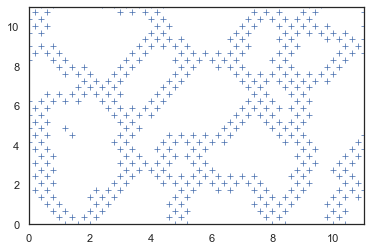

In [121]:
#plot labeled edges
rdb_slice=rdb[np.where(rdb[:,6]==1)]
print(len(rdb_slice))
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice[:,3],y=rdb_slice[:,4],marker='+')

In [67]:
# #create array to minimize memory requirement
# x=0
# for grain_ID_1_ in np.unique(rdb[:,5]):
#     for grain_ID_2_ in grain_neigh[grain_ID_1_]:
#         x+=1
# print(x)

In [245]:
#initialize misorientations and lengths/weights for histogram
avg_boundary_disorients = np.zeros((5000,1))
boundary_lens = np.zeros((5000,1))

#create point adj dict
point_adj=adj_dict(rdb)

index=0
# for each grain
for grain_ID_1_ in np.unique(rdb[:,5]):
    #get the points and edges of the grain
    rdb_slice_1_=rdb[np.where(rdb[:,5]==grain_ID_1_)]
    rdb_edge_1_=rdb_slice_1_[np.where(rdb_slice_1_[:,6]==1)]
    
    #for each neighboring grain
    for grain_ID_2_ in grain_neigh[grain_ID_1_]:
        #don't comapre the same grain
        if int(grain_ID_1_) != int(grain_ID_2_):
            #get the boundary points of grain 1 with grain 2
            rdb_boundary_1_=rdb_edge_1_[np.where(rdb_edge_1_[:,8]==grain_ID_2_)]

            #slice grain 2
            rdb_slice_2_=rdb[np.where(rdb[:,5]==grain_ID_2_)]
            rdb_edge_2_=rdb_slice_2_[np.where(rdb_slice_2_[:,6]==1)]
            rdb_boundary_2_=rdb_edge_2_[np.where(rdb_edge_2_[:,8]==grain_ID_1_)]

            #create list of boundary disorientations
            boundaries_=[]

            #find each misorientation
            for key in rdb_boundary_1_[:,9]:
                key=int(key)
                euler_one_=[rdb[key][0],rdb[key][1],rdb[key][2]]
                for value in point_adj[key]:
                    euler_two_=[rdb[value][0],rdb[value][1],rdb[value][2]]
                    vor_disorient_=disorientation(euler_one_,euler_two_,hex_sym_ops)
                    if vor_disorient_ > 15:
                        boundaries_.append(vor_disorient_)

            #get avg and append to array
            if len(boundaries_)>0:
                avg_boundary_disorient=sum(boundaries_)/len(boundaries_)
                avg_boundary_disorients[index]=avg_boundary_disorient
            else:
                avg_boundary_disorients[index]=0

            #append boundaries together
            rdb_boundary_=np.append(rdb_boundary_1_, rdb_boundary_2_, axis=0)
            
            #slice boundary
            X=rdb_boundary_[:,3:5]
            y=rdb_boundary_[:,5]
            
            #if no points, bad
            if len(X) < 2:
                break
            
            #don't sample the same grain
            if len(np.unique(y)) < 2:
                break

            #create model
            model = SVC(kernel='rbf', C=1e10, gamma=1)
            model.fit(X, y)
            #return length
            boundary_len_=svc_decision_boundary_length(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)

            # append boundary length
            boundary_lens[index]=boundary_len_
           
            index+=1

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

In [246]:
keep=np.where(avg_boundary_disorients>15)
avg_boundary_disorients_over15 = avg_boundary_disorients[keep]
boundary_lens_over15 = boundary_lens[keep]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00096108, 0.00228256, 0.00552619,
        0.0069678 , 0.01201346, 0.01369534, 0.01297453, 0.01609803,
        0.0166987 , 0.01802018, 0.01645843, 0.01765978, 0.01765978,
        0.01549736, 0.01525709, 0.01429601, 0.01585776, 0.01525709,
        0.01549736, 0.01369534, 0.01333494, 0.01645843, 0.0159779 ,
        0.01693897, 0.01369534, 0.01573763, 0.01525709, 0.01393561,
        0.01561749, 0.01525709, 0.01381547, 0.01237386, 0.01489668,
        0.01105238, 0.00961076, 0.00876982, 0.00720807, 0.00540605,
        0.00204229, 0.00024027, 0.        , 0.        ]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

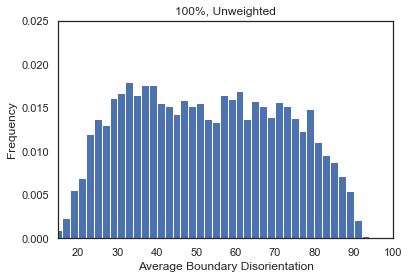

In [247]:
#unweighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Unweighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.hist(avg_boundary_disorients_over15, bins=np.arange(0,100,2), range=(0,100), density=True)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.97221270e-04,
        2.51464620e-03, 5.12763676e-03, 7.43186823e-03, 1.30229504e-02,
        1.52340102e-02, 1.58011243e-02, 1.78366551e-02, 2.00724140e-02,
        2.01762754e-02, 1.61020015e-02, 1.65124554e-02, 1.87518176e-02,
        1.60785385e-02, 1.42481651e-02, 1.33452276e-02, 1.66597955e-02,
        1.49099157e-02, 1.59592199e-02, 1.26027230e-02, 1.27239663e-02,
        1.55061594e-02, 1.40475758e-02, 1.58486334e-02, 1.12603817e-02,
        1.53033987e-02, 1.41325827e-02, 1.21313441e-02, 1.41892785e-02,
        1.54779510e-02, 1.36859461e-02, 1.32381399e-02, 1.47333928e-02,
        1.04386701e-02, 9.38852803e-03, 8.39002155e-03, 7.03667168e-03,
        7.40524054e-03, 1.85676401e-03, 2.06917599e-05, 0.00000000e+00,
        0.00000000e+00]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46

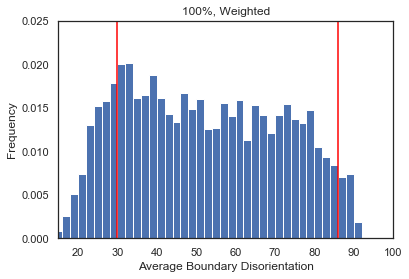

In [248]:
#weighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Weighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.axvline(x=30, color='red')
plt.axvline(86, color='red')
plt.hist(avg_boundary_disorients_over15, bins=np.arange(0,100,2), range=(0,100), density=True, weights=np.asarray(boundary_lens_over15))

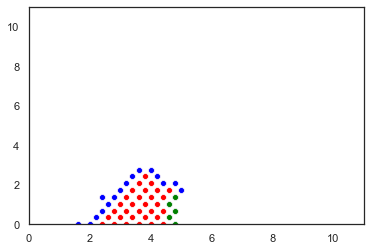

In [92]:
rdb_slice_1=rdb[np.where(rdb[:,5]==2)]
rdb_edge_1=rdb_slice_1[np.where(rdb_slice_1[:,6]==1)]
rdb_boundary_1=rdb_edge_1[np.where(rdb_edge_1[:,8]==3)]

#plot labeled grains
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice_1[:,3],y=rdb_slice_1[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_1[:,3],y=rdb_edge_1[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_1[:,3],y=rdb_boundary_1[:,4],marker='o',color='green')

In [96]:
# #create list of boundary disorientations
# boundaries=[]

# #find each misorientation
# for key in rdb_boundary_1[:,9]:
#     key=int(key)
#     euler_one=[rdb[key][0],rdb[key][1],rdb[key][2]]
#     for value in point_adj[key]:
#         euler_two=[rdb[value][0],rdb[value][1],rdb[value][2]]
#         vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
#         if vor_disorient > 15:
#             boundaries.append(vor_disorient)
            
# #get avg and append to array
# print(boundaries)
# avg=sum(boundaries)/len(boundaries)
# print(avg)

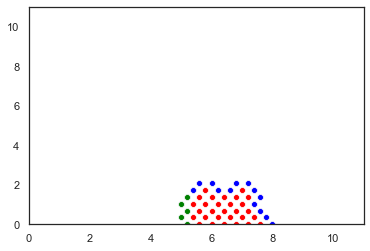

In [97]:
rdb_slice_2=rdb[np.where(rdb[:,5]==3)]
rdb_edge_2=rdb_slice_2[np.where(rdb_slice_2[:,6]==1)]
rdb_boundary_2=rdb_edge_2[np.where(rdb_edge_2[:,8]==2)]

#plot labeled grains
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice_2[:,3],y=rdb_slice_2[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_2[:,3],y=rdb_edge_2[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_2[:,3],y=rdb_boundary_2[:,4],marker='o',color='green')

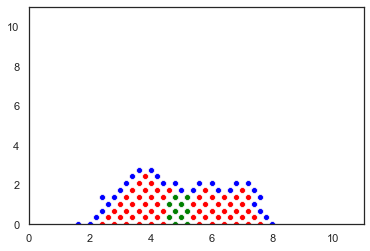

In [98]:
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice_1[:,3],y=rdb_slice_1[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_1[:,3],y=rdb_edge_1[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_1[:,3],y=rdb_boundary_1[:,4],marker='o',color='green')
sns.scatterplot(x=rdb_slice_2[:,3],y=rdb_slice_2[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_2[:,3],y=rdb_edge_2[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_2[:,3],y=rdb_boundary_2[:,4],marker='o',color='green')

In [227]:
#slice boundary
X=rdb_boundary[:,3:5]
y=rdb_boundary[:,5]

#create model
model = SVC(kernel='rbf', C=1e10, gamma=1)
model.fit(X, y)

#return length and coords of boundary
boundary_len_, boundary_coords_ = svc_decision_boundary_length_and_coords(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)

# # append boundary length
# boundary_lens[index]=boundary_len_

#create two new columns to hold nearest neighbor and a third column for misorientation
new_columns=np.zeros((len(boundary_coords_),3))
boundary_coords_=np.concatenate((boundary_coords_,new_columns),axis=1)

#row ID of nearest coord in bound1
row_1_ID=0
#for each SVM boundary point
for row_1 in boundary_coords_:
    coords_1=row_1[0:2]
    distances_and_row_IDs=defaultdict(set)
    #for each point in the first grain boundary
    for row_2 in rdb_boundary_1:
        coords_2=row_2[3:5]
        #calculate distance
        dist=round(distance.euclidean(coords_1,coords_2),3)
        #add row ID of grain boundary point for misorient
        distances_and_row_IDs[dist].add(row_2[9])
    #find minimum distance
    min_dist = min(distances_and_row_IDs.keys())
    #add row ID of min dist
    bound_1_ID=list(distances_and_row_IDs[min_dist])
    boundary_coords_[row_1_ID,2]=bound_1_ID[0]
    row_1_ID+=1       

#bound2 neighbor of each coord
row_1_ID=0
#for each SVM boundary point
for row_1 in boundary_coords_:
    coords_1=row_1[0:2]
    distances_and_row_IDs=defaultdict(set)
    #for each point in the first grain boundary
    for row_2 in rdb_boundary_2:
        coords_2=row_2[3:5]
        #calculate distance
        dist=round(distance.euclidean(coords_1,coords_2),3)
        #add row ID of grain boundary point for misorient
        distances_and_row_IDs[dist].add(row_2[9])
    #find minimum distance
    min_dist = min(distances_and_row_IDs.keys())
    #add row ID of min dist
    bound_1_ID=list(distances_and_row_IDs[min_dist])
    boundary_coords_[row_1_ID,3]=bound_1_ID[0]
    row_1_ID+=1 

# print(boundary_coords_[:,2:4])

# #calculate each misorientation
row_ID=0
for row in boundary_coords_:
    key=int(boundary_coords_[row_ID,2])-1
    euler_one_=[rdb[key][0],rdb[key][1],rdb[key][2]]
    value=int(boundary_coords_[row_ID,3])-1
    euler_two_=[rdb[value][0],rdb[value][1],rdb[value][2]]
    boundary_coords_[row_ID,4]=disorientation(euler_one_,euler_two_,hex_sym_ops)
    row_ID+=1
    
print(boundary_coords_[:,4])

# # #find the total average and append
# # avg_boundary_disorients[index]=np.mean(boundary_coords_[:,4])
            
            

[43.99800846 43.99800846 43.99800846 43.99800846 43.99800846 43.99800846
 43.99800846 43.99800846 43.99800846 43.99800846 43.99800846 44.41568315
 44.41568315 44.41568315 44.41568315 44.41568315 44.13118483 44.13118483
 44.13118483 44.13118483 44.13118483 44.13118483 44.13118483 44.13118483
 44.13118483 44.06506927 44.06506927 44.06506927 44.06506927 44.06506927
 44.06506927 44.16951652 44.16951652 44.16951652]


In [279]:
#initialize misorientations and lengths/weights for histogram
avg_boundary_disorients = np.zeros((5000,1))
boundary_lens = np.zeros((5000,1))

#create point adj dict
point_adj=adj_dict(rdb)

index=0
# for each grain
for grain_ID_1_ in np.unique(rdb[:,5]):
    #get the points and edges of the grain
    rdb_slice_1_=rdb[np.where(rdb[:,5]==grain_ID_1_)]
    rdb_edge_1_=rdb_slice_1_[np.where(rdb_slice_1_[:,6]==1)]
    
    #for each neighboring grain
    for grain_ID_2_ in grain_neigh[grain_ID_1_]:
        #don't compare the same grain
        if int(grain_ID_1_) != int(grain_ID_2_):
            #get the boundary points of grain 1 with grain 2
            rdb_boundary_1_=rdb_edge_1_[np.where(rdb_edge_1_[:,8]==grain_ID_2_)]

            #slice grain 2
            rdb_slice_2_=rdb[np.where(rdb[:,5]==grain_ID_2_)]
            rdb_edge_2_=rdb_slice_2_[np.where(rdb_slice_2_[:,6]==1)]
            rdb_boundary_2_=rdb_edge_2_[np.where(rdb_edge_2_[:,8]==grain_ID_1_)]
            
            #append boundaries together
            rdb_boundary_=np.append(rdb_boundary_1_, rdb_boundary_2_, axis=0)

            #slice boundary
            X=rdb_boundary_[:,3:5]
            y=rdb_boundary_[:,5]
            
            #if no points, bad
            if len(X) < 2:
                break
            
            #don't sample the same grain
            if len(np.unique(y)) < 2:
                break

            #create model
            model = SVC(kernel='rbf', C=1e10, gamma=1)
            model.fit(X, y)
            #return length and coords of boundary
            boundary_len_, boundary_coords_ = svc_decision_boundary_length_and_coords(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)

            # append boundary length
            boundary_lens[index]=boundary_len_

            #create two new columns to hold nearest neighbor and a third column for misorientation
            new_columns=np.zeros((len(boundary_coords_),3))
            boundary_coords_=np.concatenate((boundary_coords_,new_columns),axis=1)

            #row ID of nearest coord in bound1
            row_1_ID=0
            #for each SVM boundary point
            for row_1 in boundary_coords_:
                coords_1=row_1[0:2]
                distances_and_row_IDs=defaultdict(set)
                #for each point in the first grain boundary
                for row_2 in rdb_boundary_1_:
                    coords_2=row_2[3:5]
                    #calculate distance
                    dist=round(distance.euclidean(coords_1,coords_2),3)
                    #add row ID of grain boundary point for misorient
                    distances_and_row_IDs[dist].add(row_2[9])
                #find minimum distance
                min_dist = min(distances_and_row_IDs.keys())
                #add row ID of min dist
                bound_1_ID=list(distances_and_row_IDs[min_dist])
                boundary_coords_[row_1_ID,2]=bound_1_ID[0]
                row_1_ID+=1       

            #bound2 neighbor of each coord
            row_1_ID=0
            #for each SVM boundary point
            for row_1 in boundary_coords_:
                coords_1=row_1[0:2]
                distances_and_row_IDs=defaultdict(set)
                #for each point in the first grain boundary
                for row_2 in rdb_boundary_2_:
                    coords_2=row_2[3:5]
                    #calculate distance
                    dist=round(distance.euclidean(coords_1,coords_2),3)
                    #add row ID of grain boundary point for misorient
                    distances_and_row_IDs[dist].add(row_2[9])
                #find minimum distance
                min_dist = min(distances_and_row_IDs.keys())
                #add row ID of min dist
                bound_1_ID=list(distances_and_row_IDs[min_dist])
                boundary_coords_[row_1_ID,3]=bound_1_ID[0]
                row_1_ID+=1 

            #calculate each misorientation
            row_ID=0
            for row in boundary_coords_:
                key=int(boundary_coords_[row_ID,2])-1
                euler_one_=[rdb[key][0],rdb[key][1],rdb[key][2]]
                value=int(boundary_coords_[row_ID,3])-1
                euler_two_=[rdb[value][0],rdb[value][1],rdb[value][2]]
                boundary_coords_[row_ID,4]=disorientation(euler_one_,euler_two_,hex_sym_ops)
                row_ID+=1

            #find the total average and append
            avg_boundary_disorients[index]=np.mean(boundary_coords_[:,4])
           
            index+=1

In [280]:
keep=np.where(avg_boundary_disorients>15)
avg_boundary_disorients_over15 = avg_boundary_disorients[keep]
boundary_lens_over15 = boundary_lens[keep]

NameError: name 'avg_boundary_disorients_over15' is not defined

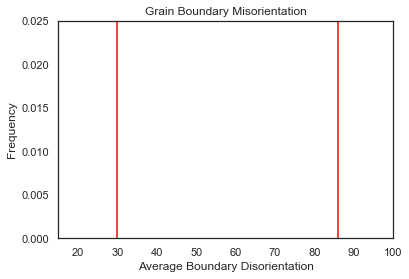

In [253]:
#unweighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("Grain Boundary Misorientation")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.axvline(x=30, color='red')
plt.axvline(86, color='red')
plt.hist(avg_boundary_disorients_over15, bins=np.arange(0,100,2), range=(0,100), density=True)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.0009582 , 0.00730682, 0.00940105,
        0.01437747, 0.01704179, 0.01726705, 0.01968343, 0.01923523,
        0.021936  , 0.01988539, 0.01589685, 0.01443155, 0.01167442,
        0.01174705, 0.01378906, 0.01298334, 0.00883493, 0.01126821,
        0.00983357, 0.01030751, 0.00938326, 0.00974664, 0.01489369,
        0.01131576, 0.01134896, 0.01253158, 0.00958693, 0.0112367 ,
        0.01323539, 0.01353383, 0.01362232, 0.00983721, 0.01301257,
        0.01446544, 0.01522718, 0.0122869 , 0.01530978, 0.01617063,
        0.00501766, 0.00037865, 0.        , 0.        ]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

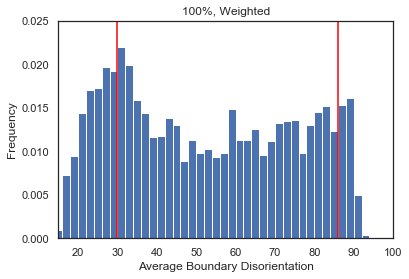

In [282]:
#weighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Weighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.axvline(x=30, color='red')
plt.axvline(86, color='red')
plt.hist(avg_boundary_disorients_over15, bins=np.arange(0,100,2), range=(0,100), density=True, weights=np.asarray(boundary_lens_over15))

In [67]:
def grain_misorients(array, hist=True):
    #add boundaries - 6
    boundaries=np.zeros((len(array),1))
    rdb=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)

    #add neighbors for rec_neighbors - 7
    neighbors=np.zeros((len(array),1))
    rdb=np.concatenate((rdb,neighbors.reshape(-1,1)),axis=1)

    #add neighbors for points/grains - 8
    rdb=np.concatenate((rdb,neighbors.reshape(-1,1)),axis=1)

    #add row_IDs for adj dict - 9
    row_IDs=np.arange(1,len(array)+1)
    rdb=np.concatenate((rdb,row_IDs.reshape(-1,1)),axis=1)

    #add column for len calculation - 10
    length=np.zeros((len(array),1))
    rdb=np.concatenate((rdb,length.reshape(-1,1)),axis=1)
    
    #create point and grain adj dicts
    point_adj=adj_dict(rdb)
    grain_neigh=label_rdb_and_create_grainadj(rdb)
    
    #initialize misorientations and lengths/weights for histogram
    avg_boundary_disorients = np.zeros((5000,1))
    boundary_lens = np.zeros((5000,1))
    
    #calculate grain misorients and lengths
    #**************************************
    
    index=0
    # for each grain
    for grain_ID_1_ in np.unique(rdb[:,5]):
        #get the points and edges of the grain
        rdb_slice_1_=rdb[np.where(rdb[:,5]==grain_ID_1_)]
        rdb_edge_1_=rdb_slice_1_[np.where(rdb_slice_1_[:,6]==1)]

        #for each neighboring grain
        for grain_ID_2_ in grain_neigh[grain_ID_1_]:
            #don't compare the same grain
            if int(grain_ID_1_) != int(grain_ID_2_):
                #get the boundary points of grain 1 with grain 2
                rdb_boundary_1_=rdb_edge_1_[np.where(rdb_edge_1_[:,8]==grain_ID_2_)]

                #slice grain 2
                rdb_slice_2_=rdb[np.where(rdb[:,5]==grain_ID_2_)]
                rdb_edge_2_=rdb_slice_2_[np.where(rdb_slice_2_[:,6]==1)]
                rdb_boundary_2_=rdb_edge_2_[np.where(rdb_edge_2_[:,8]==grain_ID_1_)]

                #append boundaries together
                rdb_boundary_=np.append(rdb_boundary_1_, rdb_boundary_2_, axis=0)

                #slice boundary
                X=rdb_boundary_[:,3:5]
                y=rdb_boundary_[:,5]

                #if no points, bad
                if len(X) < 2:
                    break

                #don't sample the same grain
                if len(np.unique(y)) < 2:
                    break

                #create model
                model = SVC(kernel='rbf', C=1e10, gamma=1)
                model.fit(X, y)
                #return length and coords of boundary
                boundary_len_, boundary_coords_ = svc_decision_boundary_length_and_coords(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)

                # append boundary length
                boundary_lens[index]=boundary_len_

                #create two new columns to hold nearest neighbor and a third column for misorientation
                new_columns=np.zeros((len(boundary_coords_),3))
                boundary_coords_=np.concatenate((boundary_coords_,new_columns),axis=1)

                #row ID of nearest coord in bound1
                row_1_ID=0
                #for each SVM boundary point
                for row_1 in boundary_coords_:
                    coords_1=row_1[0:2]
                    distances_and_row_IDs=defaultdict(set)
                    #for each point in the first grain boundary
                    for row_2 in rdb_boundary_1_:
                        coords_2=row_2[3:5]
                        #calculate distance
                        dist=round(distance.euclidean(coords_1,coords_2),3)
                        #add row ID of grain boundary point for misorient
                        distances_and_row_IDs[dist].add(row_2[9])
                    #find minimum distance
                    min_dist = min(distances_and_row_IDs.keys())
                    #add row ID of min dist
                    bound_1_ID=list(distances_and_row_IDs[min_dist])
                    boundary_coords_[row_1_ID,2]=bound_1_ID[0]
                    row_1_ID+=1       

                #bound2 neighbor of each coord
                row_1_ID=0
                #for each SVM boundary point
                for row_1 in boundary_coords_:
                    coords_1=row_1[0:2]
                    distances_and_row_IDs=defaultdict(set)
                    #for each point in the first grain boundary
                    for row_2 in rdb_boundary_2_:
                        coords_2=row_2[3:5]
                        #calculate distance
                        dist=round(distance.euclidean(coords_1,coords_2),3)
                        #add row ID of grain boundary point for misorient
                        distances_and_row_IDs[dist].add(row_2[9])
                    #find minimum distance
                    min_dist = min(distances_and_row_IDs.keys())
                    #add row ID of min dist
                    bound_1_ID=list(distances_and_row_IDs[min_dist])
                    boundary_coords_[row_1_ID,3]=bound_1_ID[0]
                    row_1_ID+=1 

                #calculate each misorientation
                row_ID=0
                for row in boundary_coords_:
                    key=int(boundary_coords_[row_ID,2])-1
                    euler_one_=[rdb[key][0],rdb[key][1],rdb[key][2]]
                    value=int(boundary_coords_[row_ID,3])-1
                    euler_two_=[rdb[value][0],rdb[value][1],rdb[value][2]]
                    boundary_coords_[row_ID,4]=disorientation(euler_one_,euler_two_,hex_sym_ops)
                    row_ID+=1

                #find the total average and append
                avg_boundary_disorients[index]=np.mean(boundary_coords_[:,4])

                index+=1
                
    #**************************************
    
    #discard misorientations below 15 degrees
    keep=np.where(avg_boundary_disorients>15)
    avg_boundary_disorients_over15 = avg_boundary_disorients[keep]
    boundary_lens_over15 = boundary_lens[keep]
    abd=avg_boundary_disorients_over15
    bl=boundary_lens_over15
    count=np.multiply(abd,bl)
    
    #plot
#     plt.xlim(15,100)
#     plt.ylim(0,0.025)
# #     plt.hist(abd, bins=np.arange(15,100,2), range=(15,100), density=True, weights=np.asarray(bl))
#     plt.title('Grain Boundary Misorientations')
#     plt.xlabel('Average Boundary Misorientation')
#     plt.ylabel('Frequency')
#     plt.hist(abd, bins=np.arange(15,100,2), range=(15,100), density=True)
    
#     q_hist, q_bin_edges = np.histogram(abd, bins=np.arange(15,100,2), range=(15,100), density=True, weights=np.asarray(bl))
    q_hist, q_bin_edges = np.histogram(abd, bins=np.arange(15,100,2), range=(15,100), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    #create histogram
    if hist==True:
        return q
    
    else:
        mean=np.mean(abd)
        var=np.var(abd)
        return mean, var

In [91]:
grain_misorient_p=grain_misorients(raw_data)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


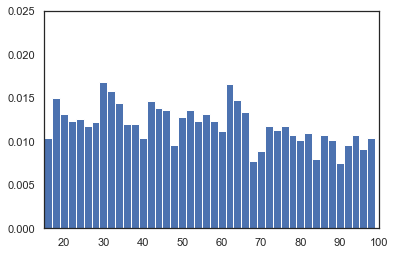

In [210]:
grain_misorient_p_2=grain_misorients(raw_data)

In [211]:
grain_misorient_unweighted=grain_misorient_p_2

In [243]:
gm_total_mean, gm_total_var=grain_misorients(raw_data,hist=False)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [87]:
def random_grain_misorient(sample, hist_bool=True):
    sliced_raw_data = raw_data[np.random.choice(raw_data.shape[0], sample, replace=False), :]
    
    if hist_bool==True:
        grain_misorient_q = grain_misorients(sliced_raw_data)
        return js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    else:
        sample_mean, sample_var = grain_misorients(sliced_raw_data,hist=False)
        return sample_mean, sample_var

def grid_grain_misorient(sample,square=True, hist_bool=True):
    phi = (np.sqrt(5)+1)/2
    ratio = np.sqrt(3)/2 # cos(60°)
    coords = raw_data[:,3:5]
    N = sample
    
    if square == True:
        N_X = int(np.sqrt(N))
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        square_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        square_coords[:,0] = square_coords[:,0] * (np.amax(raw_data[:,3]) / np.amax(square_coords[:,0]))
        square_coords[:,1] = square_coords[:,1] * (np.amax(raw_data[:,4]) / np.amax(square_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(square_coords,coords)]
        sliced_raw_data=grid_sample[:,0]
        
    else: #hexagon
        N_X = int(np.sqrt(N)/ratio)
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        xv = xv * ratio
        xv[::2, :] += ratio/2
        hex_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        hex_coords[:,0] *= (np.amax(raw_data[:,3]) / np.amax(hex_coords[:,0]))
        hex_coords[:,1] *= (np.amax(raw_data[:,4]) / np.amax(hex_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(hex_coords,coords)]
        sliced_raw_data=grid_sample[:,0]
    
    if hist_bool==True:
        grain_misorient_q = grain_misorients(sliced_raw_data)
        return js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    else:
        sample_mean, sample_var = grain_misorients(sliced_raw_data,hist=False)
        return sample_mean, sample_var

def quasirandom_grain_misorient(sample,gold=True, hist_bool=True):
    if gold == True:
        #choose 2D golden points
        golden_2D = golden(sample)
        golden_2D[:,0]*=np.amax(raw_data[:,3])
        golden_2D[:,1]*=np.amax(raw_data[:,4])
        golden_sample=raw_data[nearest_neighbors(golden_2D,coords)]
        sliced_raw_data=golden_sample[:,0]

    else:
        #choose 2D sobol points
        sobol = (sobol_seq.i4_sobol_generate(2, sample))
        sobol[:,0]*=np.amax(raw_data[:,3])
        sobol[:,1]*=np.amax(raw_data[:,4])
        sobol_sample=raw_data[nearest_neighbors(sobol,coords)]
        sliced_raw_data=sobol_sample[:,0]
    
    if hist_bool==True:
        grain_misorient_q = grain_misorients(sliced_raw_data)
        return js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    else:
        sample_mean, sample_var = grain_misorients(sliced_raw_data,hist=False)
        return sample_mean, sample_var

In [211]:
meanvar_percent_1_100=[]
for x in range (1000,10000,1000):
        meanvar_percent_1_100.append((x/87000)*100)

In [212]:
%store meanvar_percent_1_100

Stored 'meanvar_percent_1_100' (list)


In [213]:
gm_random_mean=[]
gm_random_var=[]

for x in range (1000,10000,1000):
    new_mean, new_var=random_grain_misorient(x,hist_bool=False)
    gm_random_mean.append(new_mean)
    gm_random_var.append(new_var)

gm_random_std=np.sqrt(gm_random_var)   

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

In [214]:
%store gm_random_mean
%store gm_random_var

Stored 'gm_random_mean' (list)
Stored 'gm_random_var' (list)


In [238]:
gm_sobol_mean=[]
gm_sobol_var=[]

for x in range (1000,10000,1000):
    new_mean, new_var=quasirandom_grain_misorient(x,gold=False,hist_bool=False)
    gm_sobol_mean.append(new_mean)
    gm_sobol_var.append(new_var)

gm_sobol_std=np.sqrt(gm_sobol_var)   

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

In [239]:
%store gm_sobol_mean
%store gm_sobol_var

Stored 'gm_sobol_mean' (list)
Stored 'gm_sobol_var' (list)


In [240]:
gm_square_mean=[]
gm_square_var=[]

for x in range (1000,10000,1000):
    new_mean, new_var=grid_grain_misorient(x,hist_bool=False)
    gm_square_mean.append(new_mean)
    gm_square_var.append(new_var)

gm_square_std=np.sqrt(gm_square_var)   

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

In [241]:
%store gm_square_mean
%store gm_square_var

Stored 'gm_square_mean' (list)
Stored 'gm_square_var' (list)


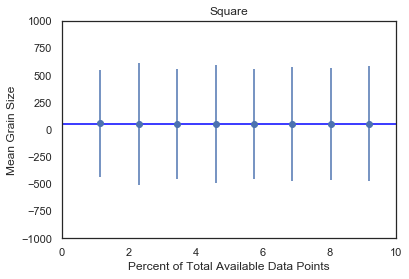

In [303]:
plt.xlim(0, 10)
# plt.ylim(0, 100)
plt.ylim(-1000,1000)
plt.title('Square')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#mean, var errorbars
# sns.scatterplot(meanvar_percent_1_100, gm_square_mean, s=100, color="blue", marker="o")
plt.errorbar(meanvar_percent_1_100, gm_square_mean, yerr=gm_square_var, fmt='o')

#actual mean
plt.axhline(y=gm_total_mean, color='blue', linestyle='-',label='total mean')

In [297]:
#         #sample further if not in the same grain
#         if grain_ID_1 != grain_ID_2:
#             #find window to sample rando values
#             x_min=rand_1[3]
#             x_max=rand_2[3]
#             y_min=rand_1[4]
#             y_max=rand_2[4]
#             if x_min > x_max:
#                 x_min,x_max=x_max,x_min            
#             if y_min > y_max:
#                 y_min,y_max=y_max,y_min

#             #slice window
#             x_in_between=raw_data[np.where((raw_data[:,3] > x_min)  & (raw_data[:,3] < x_max))]
#             in_between=x_in_between[np.where((x_in_between[:,4] > y_min)  & (x_in_between[:,4] < y_max))]

#             if len(in_between) > 0:
#                 #add new random points in window until a grain is resampled
#                 while temp_grain_ID not in sampled_grain_IDs:
#                     new_rand=in_between[np.random.choice(in_between.shape[0], 1)]
#                     temp_grain_ID=new_rand[0][5]
#                     sampled_grain_IDs.append(temp_grain_ID)
#                     row_list.append(new_rand)
#                     #only take one sample
# #                     break

In [30]:
x=defaultdict(set)
x[1].add(2)
x[2].add(3)
2 in list(x[1])

True

In [93]:
def grain_adj(array,misorient_angle=15):
    #create point adj dict
    point_neigh=adj_dict(array)
    
    #create grain adj dict
    grain_neigh=defaultdict(set)
    for key in point_neigh:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in point_neigh[key]:
            euler_two=[array[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > misorient_angle:    
                #add to adj grain dict
                grain_ID_one=array[key,5].astype(int)
                grain_ID_two=array[value,5].astype(int)
                grain_neigh[int(grain_ID_one)].add(grain_ID_two)
                grain_neigh[int(grain_ID_two)].add(grain_ID_one)
    return grain_neigh

In [165]:
#risk that there may be no grain inbetween and the samples will be wasted
def adaptive_grain_misorient(sample,num_loops):
    #raw data shape
    size=raw_data.shape[0]
    
    #mean grain diameter
    d=math.sqrt(4*total_mean/math.pi)
    
    #two random starting points
    rand_1=raw_data[np.random.choice(size, 1)]
    rand_1=rand_1[0]
    rand_2=raw_data[np.random.choice(size, 1)]
    rand_2=rand_2[0]

    #lists to hold sampled grain IDs and rows
    row_list=[]
    
    while len(row_list) < sample:
        #append first point
        row_list.append(rand_1)
        #get grain IDs
        grain_ID_1=rand_1[5]
        grain_ID_2=rand_2[5]

        #sample further if not in the same grain and there are enough points for an adj dict
        if (grain_ID_1 != grain_ID_2) and (len(row_list) > 10):
            #create grain adj dict
#             temp_row_tuple=tuple(row_list)
#             temp_raw_data=np.vstack(temp_row_tuple)
#             grain_adj_dict=grain_adj(temp_raw_data)
            
            #if shared grain voronoi edge and  distance greater than mean grain diameter 
            coords_1=rand_1[3:5]
            coords_2=rand_2[3:5]
#             if (distance.euclidean(coords_1,coords_2) > d) and (grain_ID_2 in grain_adj_dict[grain_ID_1]):   
            if (distance.euclidean(coords_1,coords_2) > d):
                #binary search
                loop_count=0
                low=coords_1
                high=coords_2
                while loop_count < num_loops:
                    lh_avg=np.average(np.vstack((low,high)), axis=0)
                    midpt=raw_data[nearest_neighbors(lh_avg.reshape(1, -1),coords)]
                    midpt=midpt[0][0]
                    midpt_coords=midpt[3:5]
                    midpt_ID=midpt[5]
                    
                    #found new grain
                    if (midpt_ID != grain_ID_1) and (midpt_ID != grain_ID_2):
#                         print('new_grain')
                        row_list.append(midpt)
                        loop_count=num_loops+1
                        break
                        
                    elif midpt_ID==grain_ID_1: 
                        low=midpt_coords
                        #keep grain 2
                        
                    else: #midpt_ID==grain_ID2
                        high=midpt_coords
                        
                    loop_count+=1
                    
#                 print(loop_count)
                    
                

        #get new random point
        rand_1=rand_2
        rand_2=raw_data[np.random.choice(size, 1)]
        rand_2=rand_2[0]
    
    row_tuple=tuple(row_list)
    sliced_raw_data=np.vstack(row_tuple)
    grain_misorient_q = grain_misorients(sliced_raw_data)
    return js_divergence_scipy(grain_misorient_p,grain_misorient_q)

In [ ]:
def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

In [ ]:
raw_data[nearest_neighbors(coords_2, coords, 6)]

In [261]:
math.sqrt(4*total_mean/math.pi)

3.917353867444172

In [277]:
#risk that there may be no grain inbetween and the samples will be wasted
def adaptive_grain_misorient_midpt(sample):
    #raw data shape
    size=raw_data.shape[0]
    
    #mean grain diameter
    d=math.sqrt(4*total_mean/math.pi)
    
    #two random starting points
    rand_1=raw_data[np.random.choice(size, 1)]
    rand_1=rand_1[0]
    rand_2=raw_data[np.random.choice(size, 1)]
    rand_2=rand_2[0]

    #lists to hold sampled grain IDs and rows
    row_list=[]
    
    while len(row_list) < sample:
        #append first point
        row_list.append(rand_1)
        #get grain IDs
        grain_ID_1=rand_1[5]
        grain_ID_2=rand_2[5]

        #sample further if not in the same grain
        if (grain_ID_1 != grain_ID_2) and (len(row_list)>6): 
#         if (grain_ID_1 != grain_ID_2):   
            #if distance greater than mean grain diameter 
            coords_1=rand_1[3:5]
            coords_2=rand_2[3:5]
            
            #and in six nearest neighbors
            temp_row_tuple=tuple(row_list)
            temp_raw_data=np.vstack(temp_row_tuple)
            temp_coords=temp_raw_data[:,3:5]
            hex_neighbors=raw_data[nearest_neighbors(coords_2.reshape(1, -1), temp_coords, 6), 3:5]
            hex_neighbors=hex_neighbors[0]
            if (distance.euclidean(coords_1,coords_2) > d) and ((hex_neighbors == coords_1).all(1).any()):
#             if (distance.euclidean(coords_1,coords_2) > d):
                print('yee')
                print(coords_1)
                print(hex_neighbors)
                #add midpoint
                loop_count=0
                low=coords_1
                high=coords_2
                lh_avg=np.average(np.vstack((low,high)), axis=0)
                midpt=raw_data[nearest_neighbors(lh_avg.reshape(1, -1),coords)]
                midpt=midpt[0][0]
                row_list.append(midpt)          

        #get new random point
        rand_1=rand_2
        rand_2=raw_data[np.random.choice(size, 1)]
        rand_2=rand_2[0]
    
    row_tuple=tuple(row_list)
    sliced_raw_data=np.vstack(row_tuple)
    grain_misorient_q = grain_misorients(sliced_raw_data)
    return js_divergence_scipy(grain_misorient_p,grain_misorient_q)

In [166]:
#say each new point added is not in the same grain, therefore an adj dict is being created each time! This is like creating 26000 adj dicts
# each might take around a minute , this gets on the order of hours - for small values! Need to refine or discard this condition.
# use nearest neighbor instead?

In [278]:
adaptive_grain_percents_1=[]
adaptive_grain_misorients_1=[]
for x in range (1000,10000,1000):
    print(x)
    adaptive_grain_percents_1.append((x/87017)*100)
    adaptive_grain_misorients_1.append(adaptive_grain_misorient_midpt(x))    

adaptive_grain_percents_1.append(0)    
adaptive_grain_misorients_1.append(1)

%store adaptive_grain_percents_1
%store adaptive_grain_misorients_1

In [279]:
adaptive_grain_misorients_3=[]
for x in range (1000,10000,1000):
    print(x)
    adaptive_grain_misorients_3.append(adaptive_grain_misorient(x,3))    

adaptive_grain_misorients_3.append(1)

%store adaptive_grain_misorients_3

In [182]:
adaptive_grain_misorients_5=[]
for x in range (1000,10000,1000):
    adaptive_grain_misorients_5.append(adaptive_grain_misorient(x,5))    

%store adaptive_grain_percents_5
%store adaptive_grain_misorients_5

In [285]:
adaptive_grain_misorients_1_6=[]
for x in range (1000,10000,1000):
    print(x)
    adaptive_grain_misorients_1_6.append(adaptive_grain_misorient_midpt(x))    

%store adaptive_grain_misorients_1_6

In [286]:
adaptive_grain_misorients_1_6.append(1)

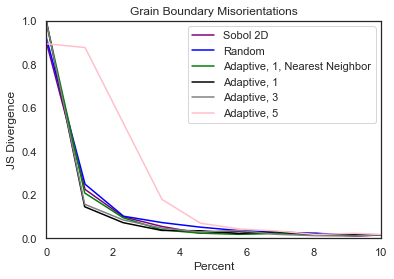

In [289]:
plt.xlim(0,10)
plt.ylim(0,1)
plt.title('Grain Boundary Misorientations')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')

#for comparison
sns.lineplot(percent_1_25,sobol_grain_misorients,label='Sobol 2D',color='purple')
sns.lineplot(percent_1_25,random_grain_misorients,label='Random',color='blue')

#adaptive
sns.lineplot(adaptive_grain_percents_1,adaptive_grain_misorients_1_6,label='Adaptive, 1, Nearest Neighbor',color='green')
sns.lineplot(adaptive_grain_percents_1,adaptive_grain_misorients_1,label='Adaptive, 1',color='black')
sns.lineplot(adaptive_grain_percents_1,adaptive_grain_misorients_3,label='Adaptive, 3',color='grey')
sns.lineplot(adaptive_grain_percents_5,adaptive_grain_misorients_5,label='Adaptive, 5',color='pink')

In [ ]:
#start with 25% of data


In [54]:
def window_grain_misorient(size):
    #define slices
    x_min=np.amin(raw_data[:,3])
    x_max=np.amax(raw_data[:,3])
    y_min=np.amin(raw_data[:,4])
    y_max=np.amax(raw_data[:,4])

    #window one (bottom left)
    raw_data_slice_1 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] <= y_max/2))]

    # #window two (bottom right)
    raw_data_slice_2 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] <= y_max/2))]
    raw_data_slice_2[:,3] -= np.min(raw_data_slice_2[:,3])

    # #window three (top left)
    raw_data_slice_3 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] >= y_max/2))]
    raw_data_slice_3[:,4] -= np.min(raw_data_slice_3[:,4])

    # #window four (top right)
    raw_data_slice_4 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] >= y_max/2))]
    raw_data_slice_4[:,3] -= np.min(raw_data_slice_4[:,3])
    raw_data_slice_4[:,4] -= np.min(raw_data_slice_4[:,4])
    
#     percent=size/len(raw_data)*100
#     print(percent)
#     percent=sqrt(percent*100)
#     print(percent)
#     percent=percent/100
#     print(110*percent)


    percent=sqrt(size/len(raw_data))
    print(110*percent)
    

    #Divergence One
    raw_data_slice=raw_data_slice_1
    
    row_list=[]
    for index in range(0,len(raw_data_slice)):
        if (raw_data_slice[index,3]<=int((110*percent))) and (raw_data_slice[index,4]<=int((110*percent))):
            row_list.append(raw_data_slice[index])
        else:
            continue

    row_tuple=tuple(row_list)
    sliced_raw_data_slice=np.vstack(row_tuple)
    print(len(sliced_raw_data_slice))
    grain_misorient_q = grain_misorients(sliced_raw_data_slice)
    divergence_1=js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    #Divergence Two
    raw_data_slice=raw_data_slice_2

    row_list=[]
    for index in range(0,len(raw_data_slice)):
        if (raw_data_slice[index,3]<=int((110*percent))) and (raw_data_slice[index,4]<=int((110*percent))):
            row_list.append(raw_data_slice[index])
        else:
            continue

    row_tuple=tuple(row_list)
    sliced_raw_data_slice=np.vstack(row_tuple)
    grain_misorient_q = grain_misorients(sliced_raw_data_slice)
    divergence_2=js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    #Divergence Three
    raw_data_slice=raw_data_slice_3
    
    row_list=[]
    for index in range(0,len(raw_data_slice)):
        if (raw_data_slice[index,3]<=int((110*percent))) and (raw_data_slice[index,4]<=int((110*percent))):
            row_list.append(raw_data_slice[index])
        else:
            continue

    row_tuple=tuple(row_list)
    sliced_raw_data_slice=np.vstack(row_tuple)
    grain_misorient_q = grain_misorients(sliced_raw_data_slice)
    divergence_3=js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    #Divergence Four
    raw_data_slice=raw_data_slice_4

    row_list=[]
    for index in range(0,len(raw_data_slice)):
        if (raw_data_slice[index,3]<=int((110*percent))) and (raw_data_slice[index,4]<=int((110*percent))):
            row_list.append(raw_data_slice[index])
        else:
            continue

    row_tuple=tuple(row_list)
    sliced_raw_data_slice=np.vstack(row_tuple)
    grain_misorient_q = grain_misorients(sliced_raw_data_slice)
    divergence_4=js_divergence_scipy(grain_misorient_p,grain_misorient_q)
    
    #Return Average
    return (divergence_1+divergence_2+divergence_3+divergence_4)/4

In [55]:
window_grain_misorient(21900)

55.183938032636114
21863


NameError: name 'grain_misorients' is not defined

In [214]:
# window_percent_1_25=[]
# window_grain_misorients=[]
# for x in range (1,26,1):
#     window_percent_1_25.append(x)
#     window_grain_misorients.append(window_grain_misorient(sqrt(x*100)))

In [122]:
# %store window_percent_1_25
# %store window_grain_misorients

Stored 'window_percent_1_25' (list)
Stored 'window_grain_misorients' (list)


In [123]:
percent_1_25=[] 
# random_grain_misorients=[]
for x in range (10,26000,1000):
    percent_1_25.append((x/87000)*100)
#     random_grain_misorients.append(random_grain_misorient(x))    

In [ ]:
%store meanvar_percent_1_100
%store gm_random_mean
%store gm_random_var

In [65]:
# square_grid_grain_misorients=[]
# for x in range (10,26000,1000):
#     square_grid_grain_misorients.append(grid_grain_misorient(x))    

# hex_grid_grain_misorients=[]
# for x in range (10,26000,1000):
#     hex_grid_grain_misorients.append(grid_grain_misorient(x,square=False))    

In [63]:
# %store percent_1_25
# %store random_grain_misorients

# %store square_grid_grain_misorients
# %store hex_grid_grain_misorients

Stored 'percent_1_25' (list)
Stored 'random_grain_misorients' (list)


In [78]:
# golden_grain_misorients=[]
# for x in range (10,26000,1000):
#     golden_grain_misorients.append(quasirandom_grain_misorient(x))    

In [83]:
# sobol_grain_misorients=[]
# for x in range (10,26000,1000):
#     sobol_grain_misorients.append(quasirandom_grain_misorient(x,gold=False))    

In [84]:
# %store golden_grain_misorients
# %store sobol_grain_misorients

Stored 'golden_grain_misorients' (list)
Stored 'sobol_grain_misorients' (list)


In [87]:
# percent_1_25.append(0)
# random_grain_misorients.append(1)
# square_grid_grain_misorients.append(1)
# hex_grid_grain_misorients.append(1)
# golden_grain_misorients.append(1)
# sobol_grain_misorients.append(1)

In [117]:
# window_percent_1_25.append(0)
# window_grain_misorients.append(1)

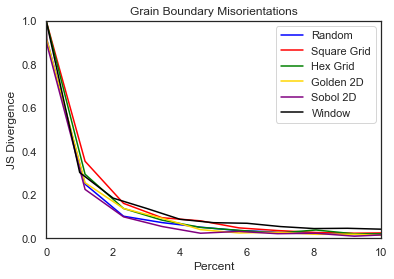

In [118]:
plt.xlim(0,10)
plt.ylim(0,1)
plt.title('Grain Boundary Misorientations')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')
sns.lineplot(percent_1_25,random_grain_misorients,label='Random',color='blue')
sns.lineplot(percent_1_25,square_grid_grain_misorients,label='Square Grid',color='red')
sns.lineplot(percent_1_25,hex_grid_grain_misorients,label='Hex Grid',color='green')
sns.lineplot(percent_1_25,golden_grain_misorients,label='Golden 2D',color='gold')
sns.lineplot(percent_1_25,sobol_grain_misorients,label='Sobol 2D',color='purple')
sns.lineplot(window_percent_1_25,window_grain_misorients,label='Window',color='black')
sns.lineplot(percent_1_25,adaptive_grain_misorients,label='Adaptive',color='grey')

In [184]:
print(len(percent_1_25))
print(len(adaptive_grain_misorients))

27
53


In [189]:
adaptive_grain_misorients_2=adaptive_grain_misorients[27:53]
adaptive_grain_misorients=adaptive_grain_misorients[0:27]

In [192]:
%store adaptive_grain_misorients
%store adaptive_grain_misorients_2

Stored 'adaptive_grain_misorients' (list)
Stored 'adaptive_grain_misorients_2' (list)


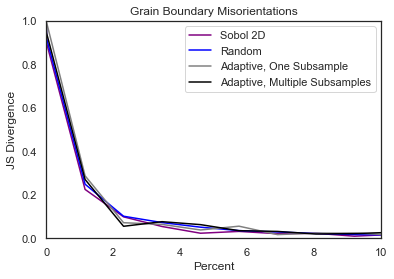

In [194]:
plt.xlim(0,10)
plt.ylim(0,1)
plt.title('Grain Boundary Misorientations')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')
sns.lineplot(percent_1_25,sobol_grain_misorients,label='Sobol 2D',color='purple')
sns.lineplot(percent_1_25,random_grain_misorients,label='Random',color='blue')
sns.lineplot(percent_1_25,adaptive_grain_misorients,label='Adaptive, One Subsample',color='grey')
sns.lineplot(percent_1_25,adaptive_grain_misorients_2,label='Adaptive, Multiple Subsamples',color='black')

In [121]:
print(adaptive_grain_misorients)

[0.8430187639137813, 0.14501628502257147, 0.09867930415905905, 0.046242485162950334, 0.025556045076894407]


In [ ]:
#looks good so far, but creating two adj dicts takes too long, need to make more local

In [ ]:
#1114 grain points vs 37014 boundary points
#also check how the algorithm performs with low values, i.e. does the SVM work or is the length zero?